<h3>Whats this about:</h3>
<div style="line-height:24px; font-size:16px">    
    This notebook explores working with actigraphy time series recordings to get an idea of the data at hand.
    <ul style="list-style:circle">
        <li>Investigate data quality (e.g., time gaps, non-wear periods, battery issues)
        <li>Calculate main statistics for all participants
        <li>Derive meaningful insights for feature engineering (circadian rhythms, time-based activity trends, activity levels, etc.)
    </ul>
    <div style="margin-top:20px;">
        Tabular features EDA notebook is <a href="https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-features-eda">here</a>
    </div>
</div>

<div style="display: flex; justify-content: flex-start; align-items: flex-start; text-align: left;">
    <img src="https://media.giphy.com/media/O1782Dz7UIITFApqZJ/giphy.gif?cid=ecf05e475s2z324hgpglklck1u2rrv02x6dpi7sldl9psfwy&ep=v1_gifs_search&rid=giphy.gif&ct=g" style="max-width: 3%; margin-right: 10px;">
    <span style="display: inline-block;">Under some section (no motion periods, circadian rhythms and others) I added ideas for feature engineering, with some code just to demonstrate the principle (will add more). But to generate features you need to clean the data first, e.g. for the participant I examine here - it is worth removing the data after day 36.</span>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

Function to plot ENMO, Angle Z, Light and any other column on below each other.

In [2]:
def plot_series_data(df, col='non-wear_flag',
                     label='Worn (0 = Worn, 1 = Not Worn)',
                     title='Non-Wear Flag',
                     x_col='day_time', x_label='Day Relative to PCIAT + Time'):
    plt.figure(figsize=(18, 12))
    
    # ENMO
    plt.subplot(4, 1, 1)
    plt.scatter(df[x_col], df['enmo'], label='ENMO', color='green', s=1)
    plt.title('ENMO (Euclidean Norm Minus One)')
    plt.ylabel('Movement Intensity')

    # Angle Z
    plt.subplot(4, 1, 2)
    plt.scatter(df[x_col], df['anglez'], label='Angle Z', color='blue', s=1)
    plt.title('Angle Z')
    plt.ylabel('Angle (degrees)')

    # Light
    plt.subplot(4, 1, 3)
    plt.scatter(df[x_col], df['light'], label='Light', color='orange', s=1)
    plt.title('Ambient Light')
    plt.ylabel('Light (lux)')

    # Any other column
    plt.subplot(4, 1, 4)
    plt.scatter(df[x_col], df[col], label=col, color='red', s=1)
    plt.title(f'{title}')
    plt.ylabel(f'{label}')
    plt.xlabel(f'{x_label}')

    plt.tight_layout()
    plt.show()

# One participant data preview

In [3]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

In [4]:
path = '/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet'
series_train = pd.read_parquet(path)
series_train

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.021536,0.022214,-1.022370,0.022853,-88.280762,0.0,53.000000,4188.000000,56940000000000,4,3,41.0
1,1,0.022005,0.022187,-1.019740,0.020231,-88.241707,0.0,51.666668,4188.166504,56945000000000,4,3,41.0
2,2,0.022240,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4188.333496,56950000000000,4,3,41.0
3,3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.500000,4188.500000,56955000000000,4,3,41.0
4,4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4181.000000,57235000000000,4,3,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43325,43325,-0.008333,-0.023620,-1.006901,0.007224,-88.595741,0.0,0.000000,3824.000000,57580000000000,6,3,85.0
43326,43326,0.048730,-0.076725,-0.953776,0.056839,-85.352219,0.0,0.000000,3824.000000,57640000000000,6,3,85.0
43327,43327,0.387370,0.793151,-0.402214,0.069961,-24.097908,0.0,0.000000,3824.000000,57645000000000,6,3,85.0
43328,43328,0.801953,0.501589,-0.040937,0.045489,-2.113776,0.0,0.000000,3824.000000,57650000000000,6,3,85.0


The description of the actigraphy data columns and my comments below each one:

**series_{train|test}.parquet/id={id}** - Series to be used as training data, partitioned by id. Each series is a continuous recording of accelerometer data for a single subject spanning many days.

- id - The patient identifier corresponding to the id field in train/test.csv.
- step - An integer timestep for each observation within a series.  

> Corresponds to sequential data collection points.

- X, Y, Z - Measure of acceleration, in g, experienced by the wrist-worn watch along each standard axis.

> The three-dimensional accelerometer readings, describe the physical movement of the person wearing the device

- enmo - As calculated and described by the wristpy package, ENMO is the Euclidean Norm Minus One of all accelerometer signals (along each of the x-, y-, and z-axis, measured in g-force) with negative values rounded to zero. Zero values are indicative of periods of no motion. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.

> A scalar value for the level of motion, where higher values indicate more activity, and zeros - of no motion

- anglez - As calculated and described by the wristpy package, Angle-Z is a metric derived from individual accelerometer components and refers to the angle of the arm relative to the horizontal plane.

> Provide information about posture or how the arm is positioned during the activity

- non-wear_flag - A flag (0: watch is being worn, 1: the watch is not worn) to help determine periods when the watch has been removed, based on the GGIR definition, which uses the standard deviation and range of the accelerometer data.

> Would be great to know how it was calculated (I can see the `detect_nonwear` function in the wristpy package, but was it used? what were the parameters at least?)

- light - Measure of ambient light in lux. See [here](https://actigraphcorp.my.site.com/support/s/article/Lux-Measurements) for details.

> May help distinguish between different times of day (day vs. night) or types of activities (e.g., being indoors or outdoors)

- battery_voltage - A measure of the battery voltage in mV.

> Unlikely to be important for modeling, but may help in identifying issues related to the data collection process (low battery voltage might align with gaps, inconsistencies, or interruptions in the data)

- time_of_day - Time of day representing the start of a 5s window that the data has been sampled over, with format %H:%M:%S.%9f.

> Again as @AmbrosM have been already said, this description is not true. Time of the day was measured in nanoseconds since midnight.

- weekday - The day of the week, coded as an integer with 1 being Monday and 7 being Sunday.

> This could provide insights into behavior patterns during weekdays versus weekends

- quarter - The quarter of the year, an integer from 1 to 4.

> Could be relevant if there are seasonal patterns in activity (e.g., more outdoor activity in summer)

- relative_date_PCIAT - The number of days (integer) since the PCIAT test was administered (negative days indicate that the actigraphy data has been collected before the test was administered).

> Seems clear

The mentioned Wristpy package is here: [Wrist-Worn Accelerometer Data Processing](https://github.com/childmindresearch/wristpy)

Participant's info:

In [5]:
participant_id = path.split('/')[-2].split('=')[-1]
participant_id

'00115b9f'

In [6]:
train[train['id'] == participant_id]

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0


Plot data by steps:

So we'll look at the data collected from a 6-year-old girl, with no data on sleep or activity based on Physical Activity Questionnaire, who spends no time on the Internet and has an SII of 0. 

Her physical data includes a BMI of 15.48, height of 45.5 inches, and weight of 45.6 pounds, normal blood pressure readings (Systolic: 115, Diastolic: 73), and a heart rate of 86 bpm

The fitness endurance test shows a max stage of 6, with a duration of 9 minutes and 5 seconds.

The girl completed a small number of curl-ups, no push-ups, and had moderate sit-and-reach flexibility on both sides. There is missing data for grip strength tests, and the participant's trunk lift performance is in zone 1.0

**A CGAS score of 40 suggests that the child has significant impairment in daily functioning**

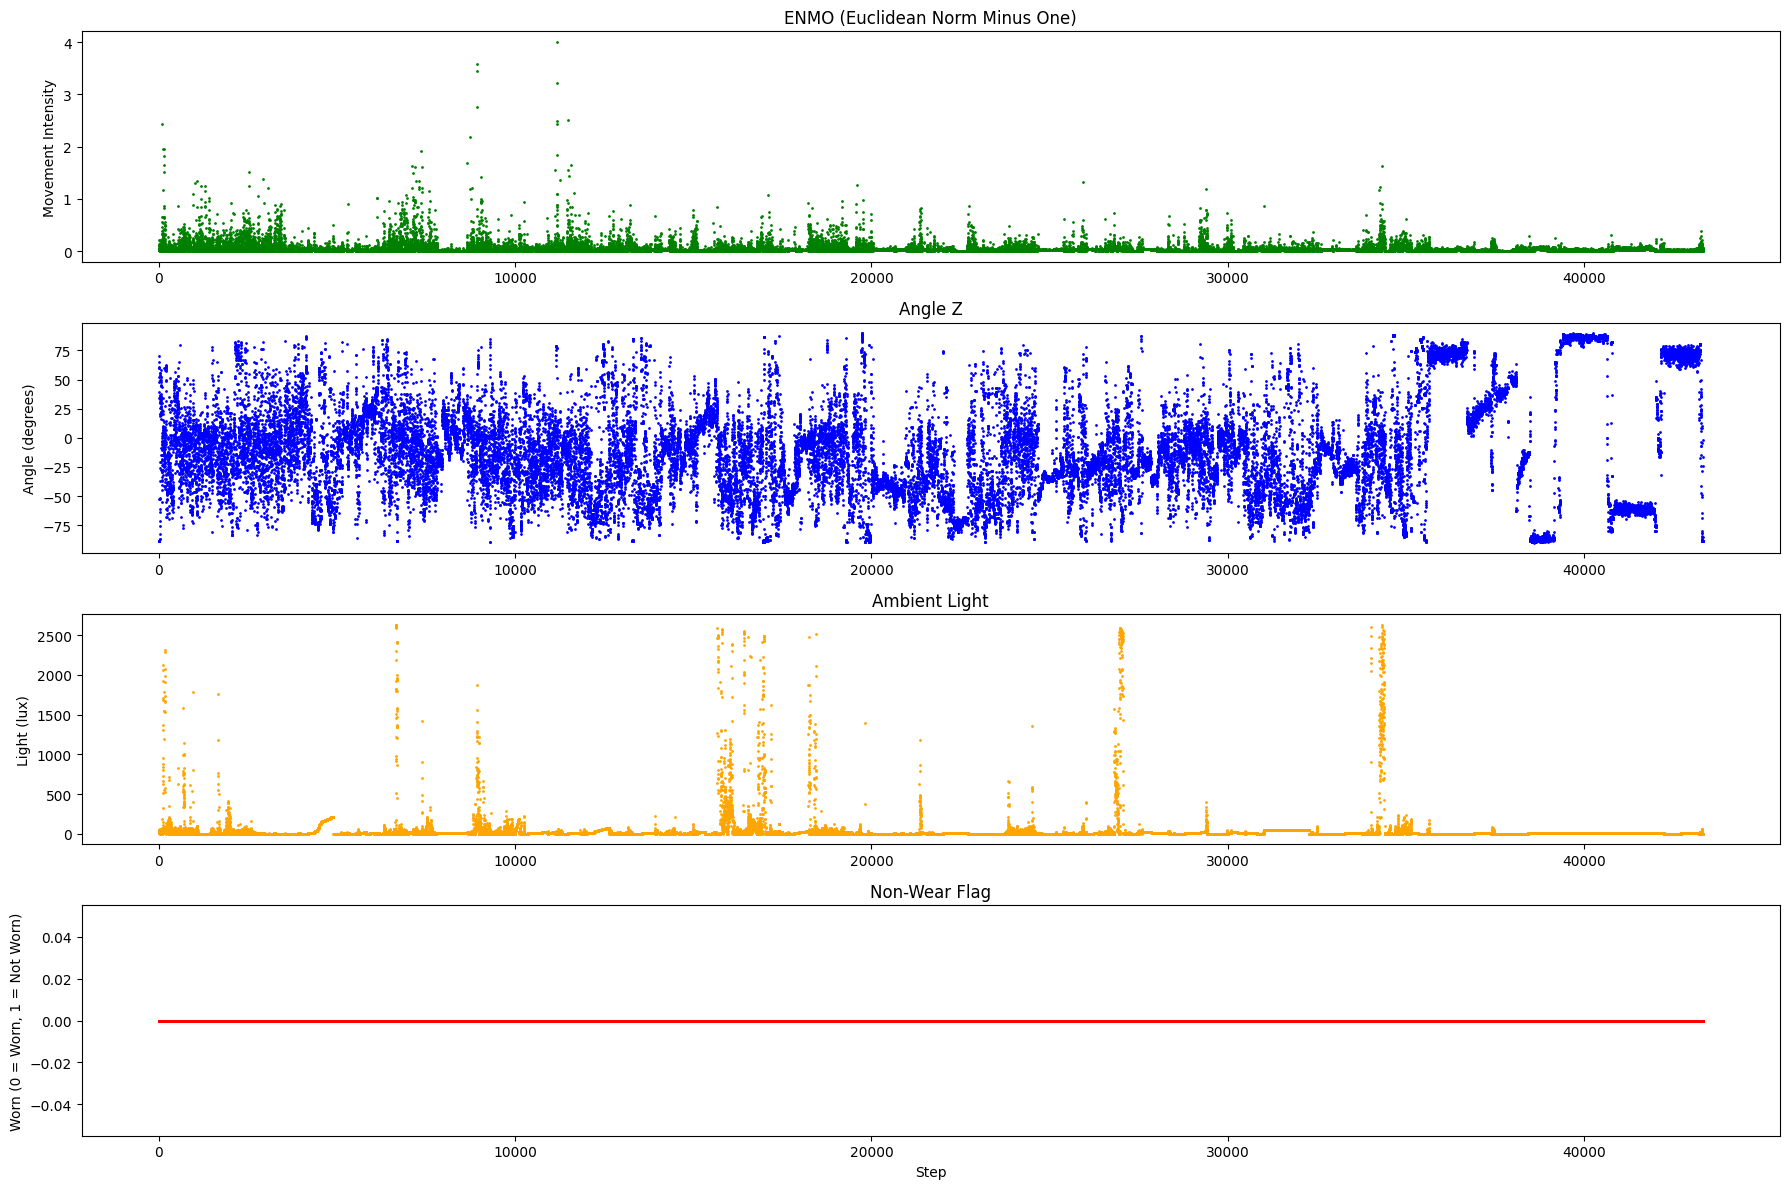

In [7]:
plot_series_data(series_train, x_col='step', x_label='Step')

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: Looks ok, and the wear flag looks correct (always indicating that the device was worn). But when using the step column as the x-axis, the time points are assumed to be equidistant, meaning that each step represents a uniform interval (e.g., every 5 seconds). But in reality, there may be irregular time gaps between data points.
</div>

Create a continuous time scale in days by transforming the `time_of_day` column (which is in nanoseconds) to hours and then combining it with `relative_date_PCIAT`:

In [8]:
series_train['time_of_day_hours'] = (
    series_train['time_of_day'] / 1e9 / 3600 #nanoseconds to hours
)
series_train['day_time'] = series_train['relative_date_PCIAT'] + (
    series_train['time_of_day_hours'] / 24
)
series_train['day_time']

0        41.659028
1        41.659086
2        41.659144
3        41.659201
4        41.662442
           ...    
43325    85.666435
43326    85.667130
43327    85.667187
43328    85.667245
43329    85.667303
Name: day_time, Length: 43330, dtype: float64

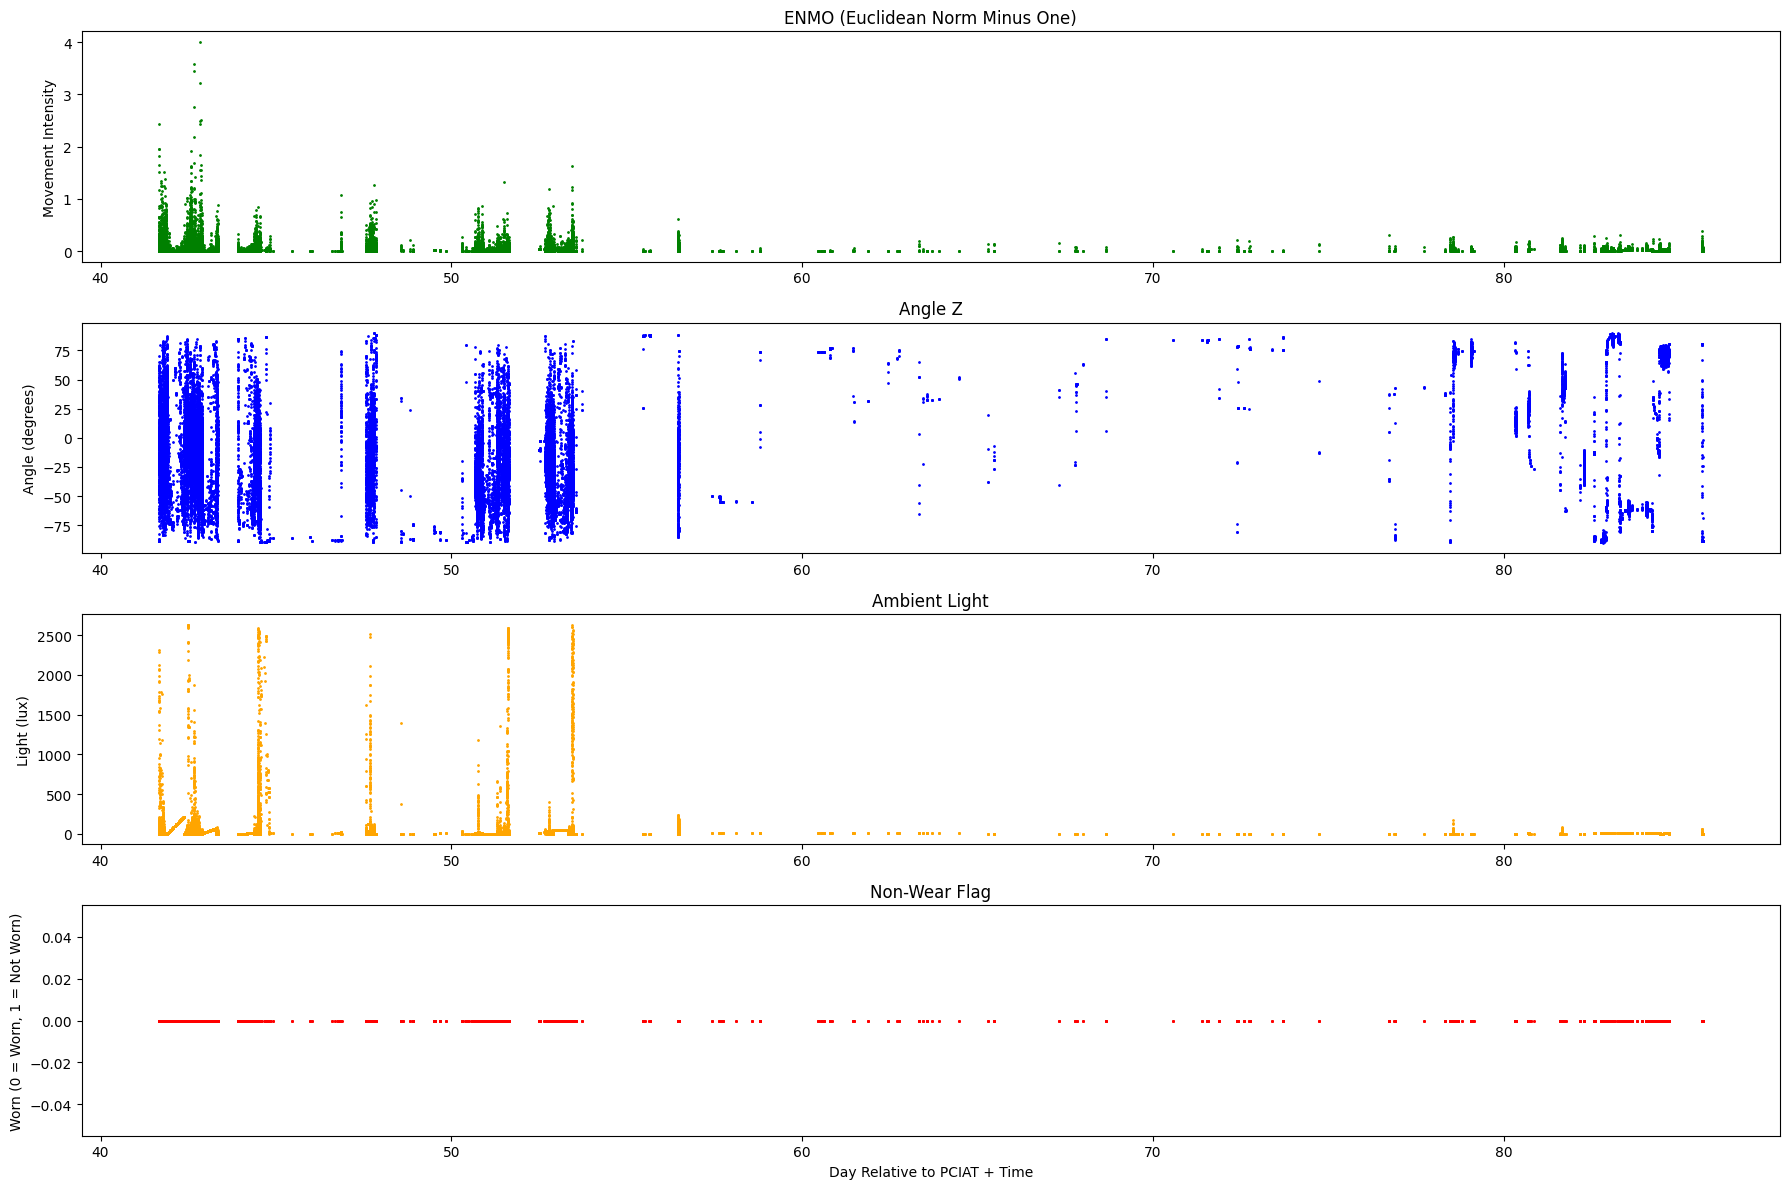

In [9]:
plot_series_data(series_train, x_col='day_time', x_label='Day Relative to PCIAT + Time')

In [10]:
len(series_train[series_train['relative_date_PCIAT'] > 36])

43330

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: Here, the data is plotted with real time on the x-axis, revealing gaps (especially on the right end) - the data for a few last weeks (after day 36) is only 1,830 measurements out of 287,179. These gaps suggest that some data was either not collected at all or was intentionally cut. Let's zoom in.
</div>

Plot data for specific day(s):

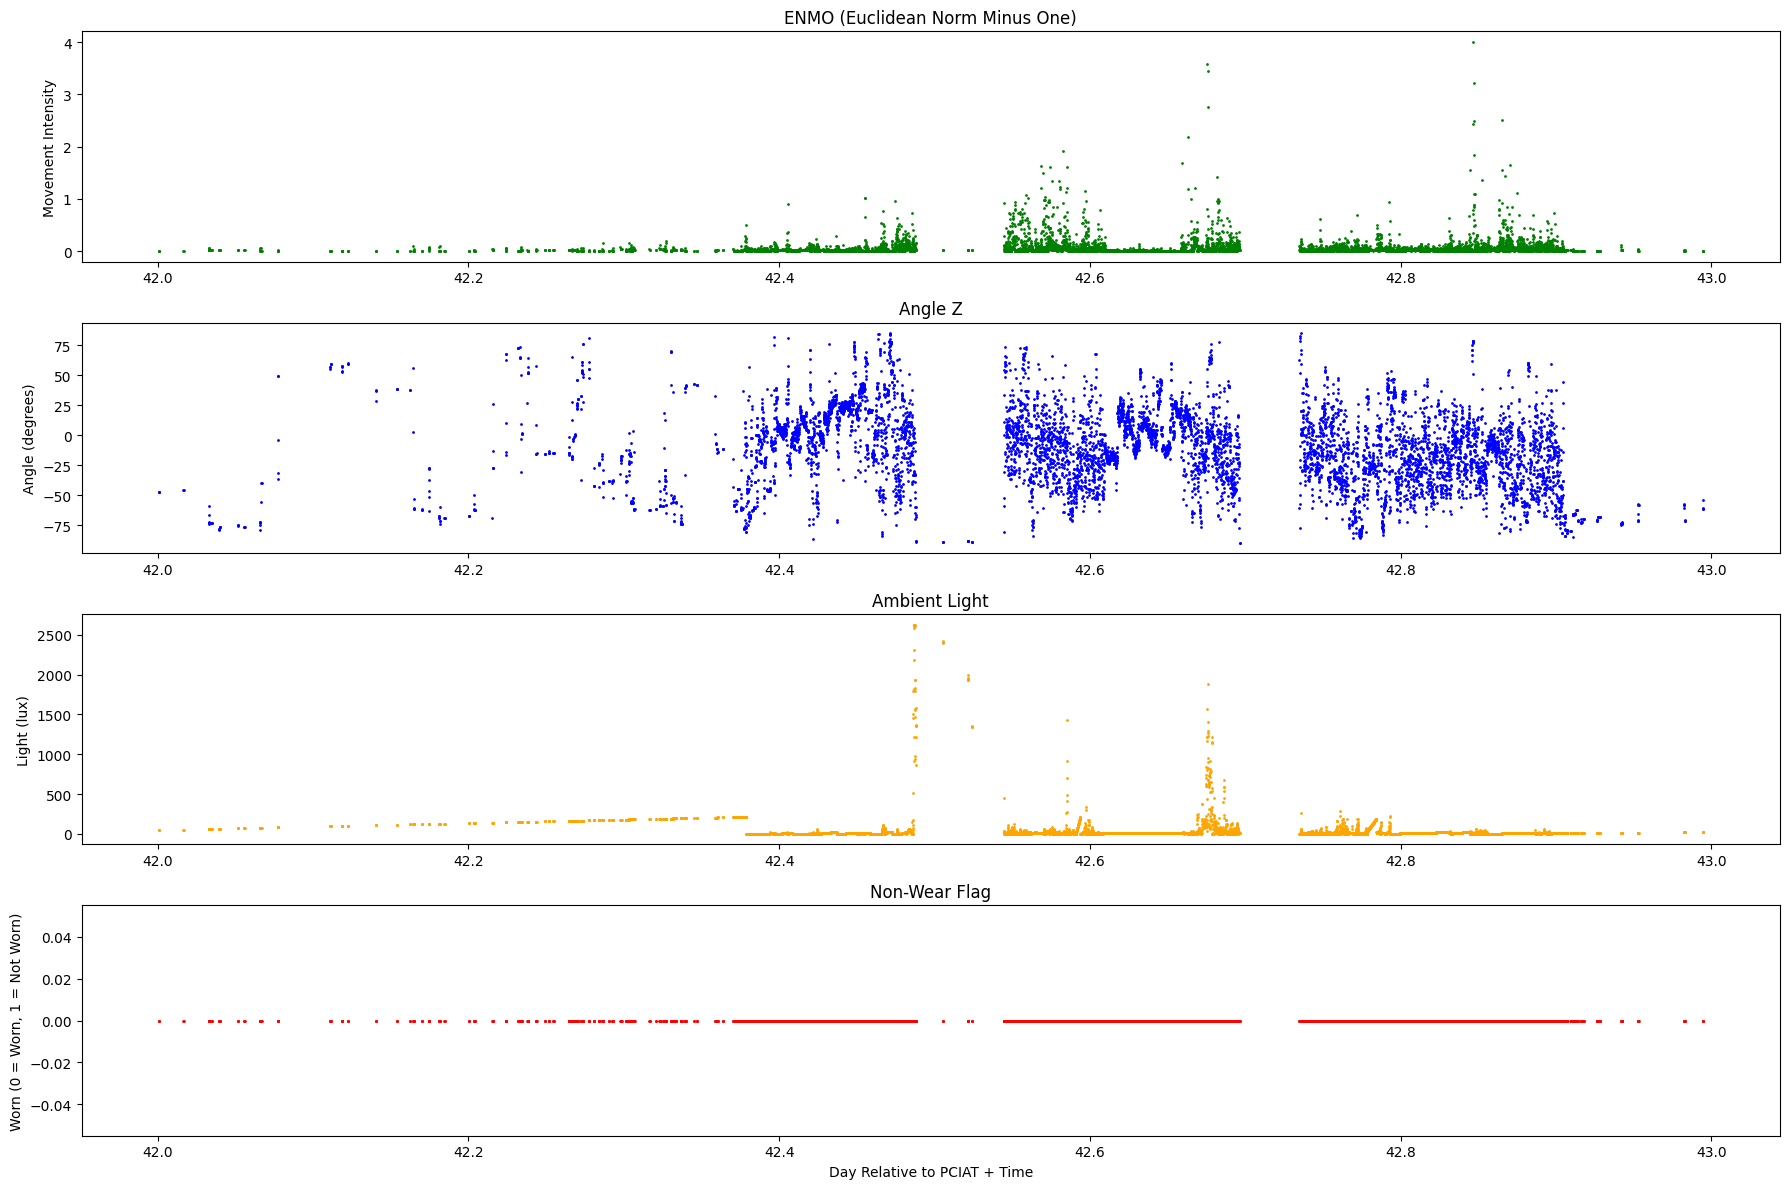

In [11]:
start_day = 2 # second day of wearing the device
show_days = 1

first_day = min(series_train['relative_date_PCIAT']) + start_day - 1
filtered_data = series_train[
    (series_train['relative_date_PCIAT'] >= first_day) &
    (series_train['relative_date_PCIAT'] <= first_day + show_days - 1)
].copy()

plot_series_data(filtered_data)

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>The left part of the plot likely represents sleep time.
<li>The activity level peaks in the middle of the day.
<li>The spikes in the ENMO, Angle Z, and Ambient Light suggest short bursts of activity that may correspond to specific tasks or movements, but there are many periods of low or no movement, and the overall pattern of activity appears to be consistent with significant impairment in daily functioning according to the CGAS score.
<li>For a healty child of this age, you would generally expect to see more consistent periods of active movement throughout the day, especially during the daytime hours when children typically play, run, etc.
    </ul>
</div>

Plot data for specific hour(s):

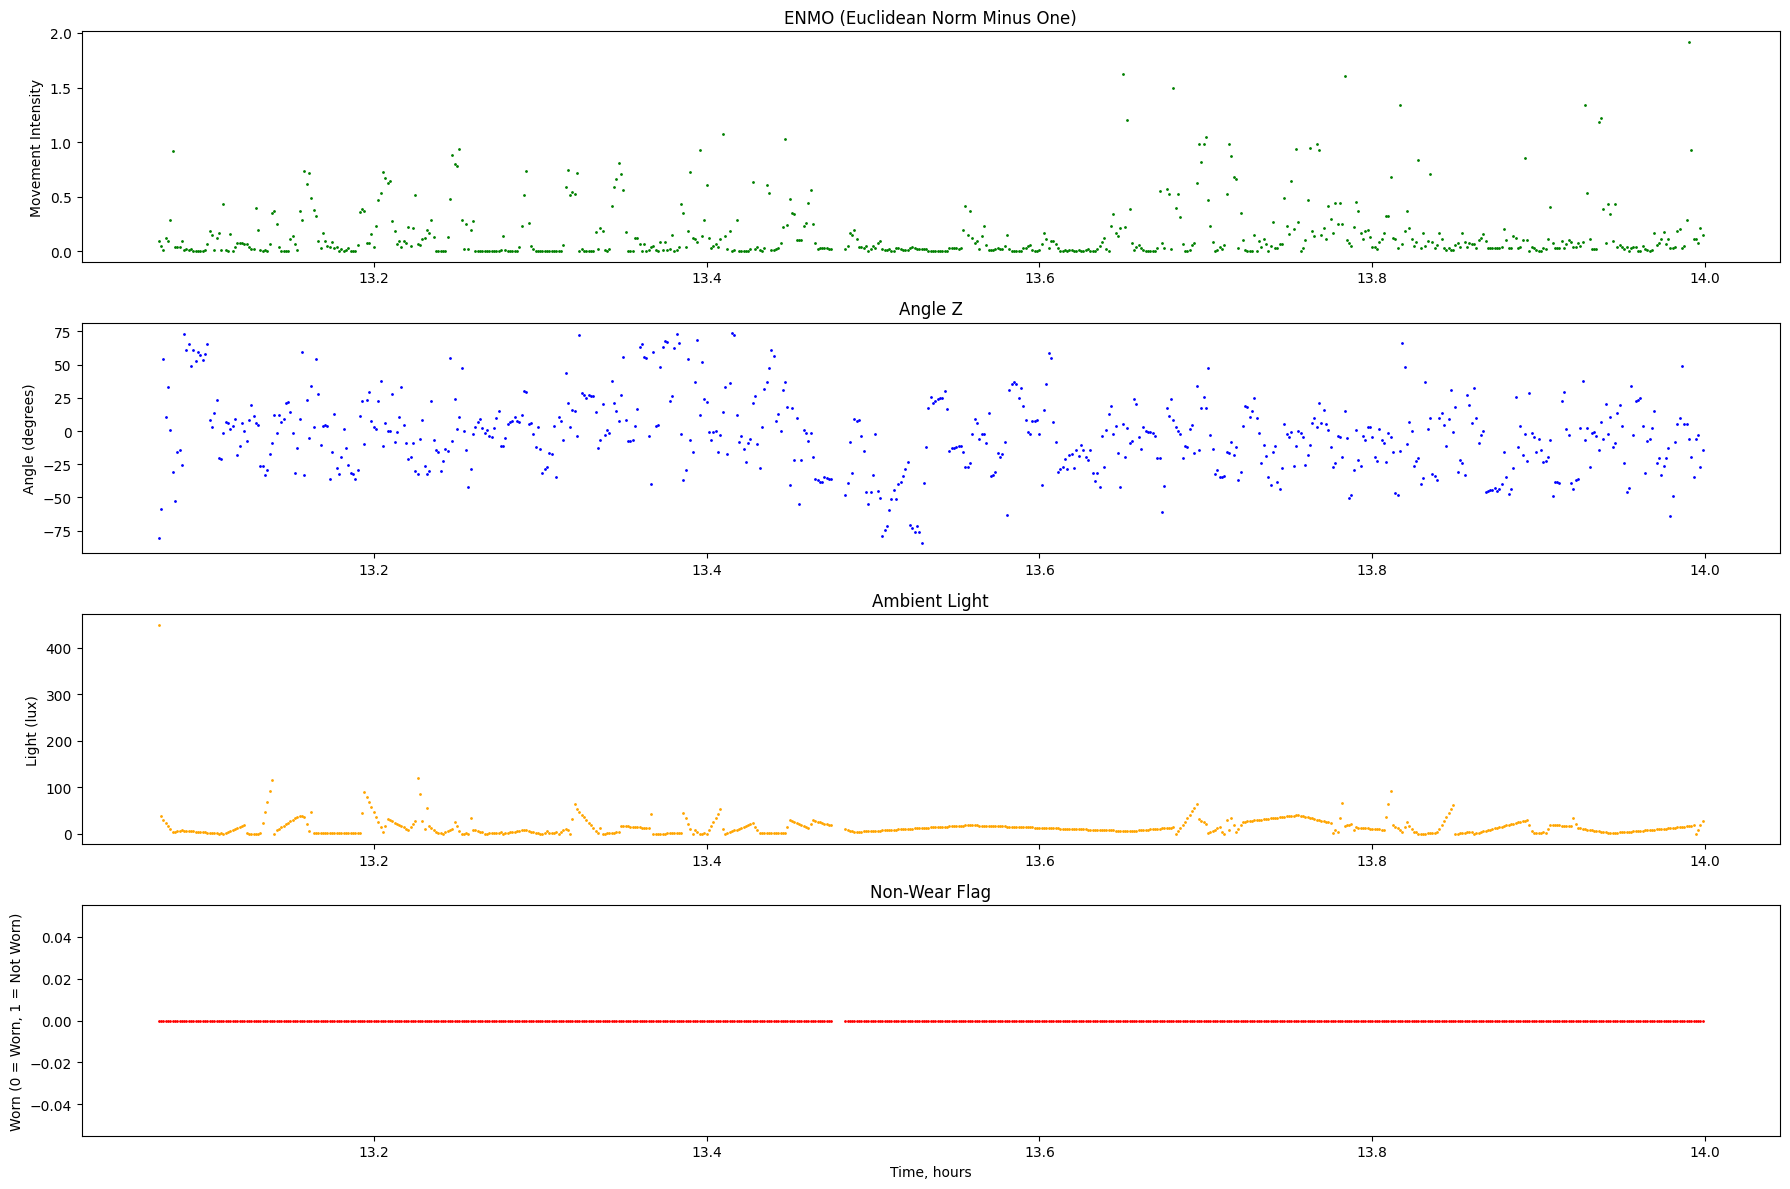

In [12]:
show_day = 2 # show second day
hour_from = 13 # starting from 1 pm
hour_to = 14 # to 2 pm

show_day = min(series_train['relative_date_PCIAT']) + show_day - 1
filtered_data = series_train[
    (series_train['relative_date_PCIAT'] == show_day) &
    (series_train['time_of_day_hours'] >= hour_from) & 
    (series_train['time_of_day_hours'] < hour_to)
].copy()

plot_series_data(filtered_data, x_col='time_of_day_hours', x_label='Time, hours')

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>The ENMO (Euclidean Norm Minus One) shows small but continuous movement, and there are changes in orientation, indicating that even minor movements are detected, which can be interpreted as the device being worn.
<li>The same is true if we look at any day within the last 2 weeks, where there are few measurements left, yet the worn flag seems to align well with movement patterns.
<li>The light data in this part of the plot does not look completely consistent or reliable, especially because of the flatline, linear trend in the middle and sudden changes (data processing artifacts?). 
    </ul>
</div>

Maybe the data has been truncated for periods of low battery? Let's check the battery voltage over time.

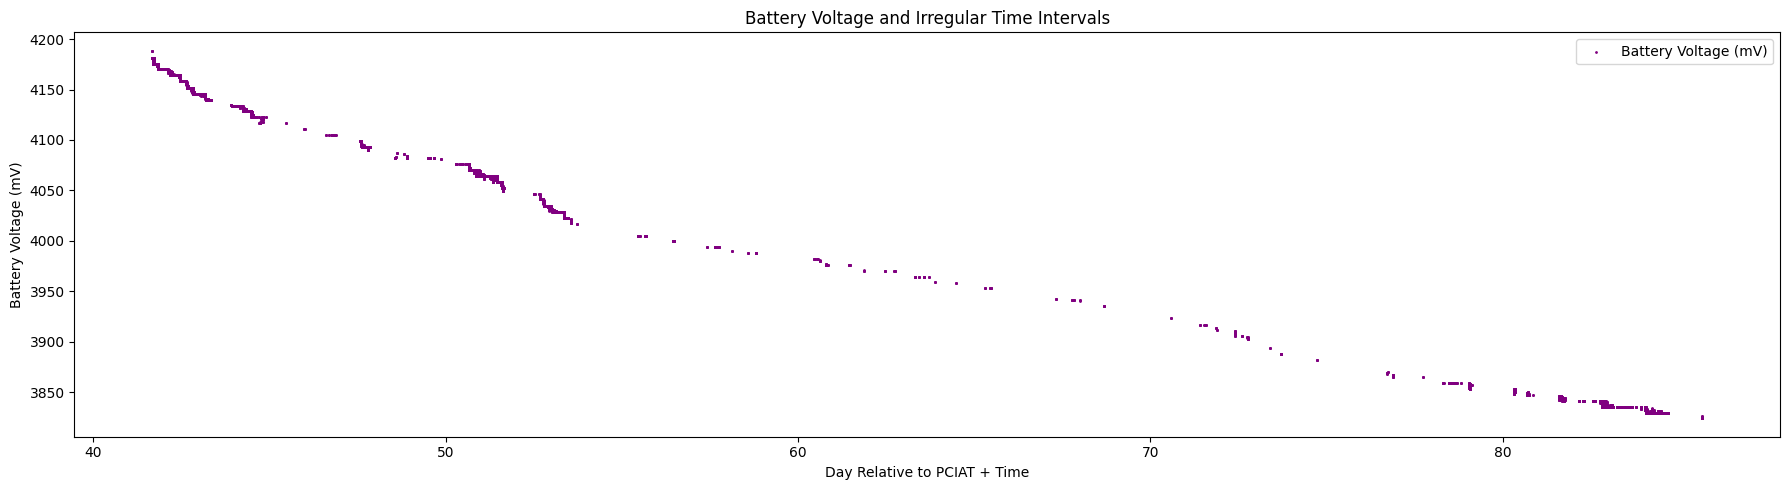

In [13]:
plt.figure(figsize=(18, 5))

plt.scatter(series_train['day_time'], series_train['battery_voltage'], 
            color='purple', label='Battery Voltage (mV)', s=1)

plt.xlabel('Day Relative to PCIAT + Time')
plt.ylabel('Battery Voltage (mV)')
plt.title('Battery Voltage and Irregular Time Intervals')
plt.legend()

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: The battery did not seem to run out completely at the end. I guess, the smooth decline suggests that the device was likely functioning properly during this time.
</div> 

# - Day/nigth periods

Use the time data to categorize the day and night. Daytime is set between 8 AM and 9 PM.

In [14]:
day_start_hour = 8
day_end_hour = 21

series_train['day_period'] = np.where(
    (series_train['time_of_day_hours'] >= day_start_hour) &
    (series_train['time_of_day_hours'] < day_end_hour),
    'day', 'night'
)

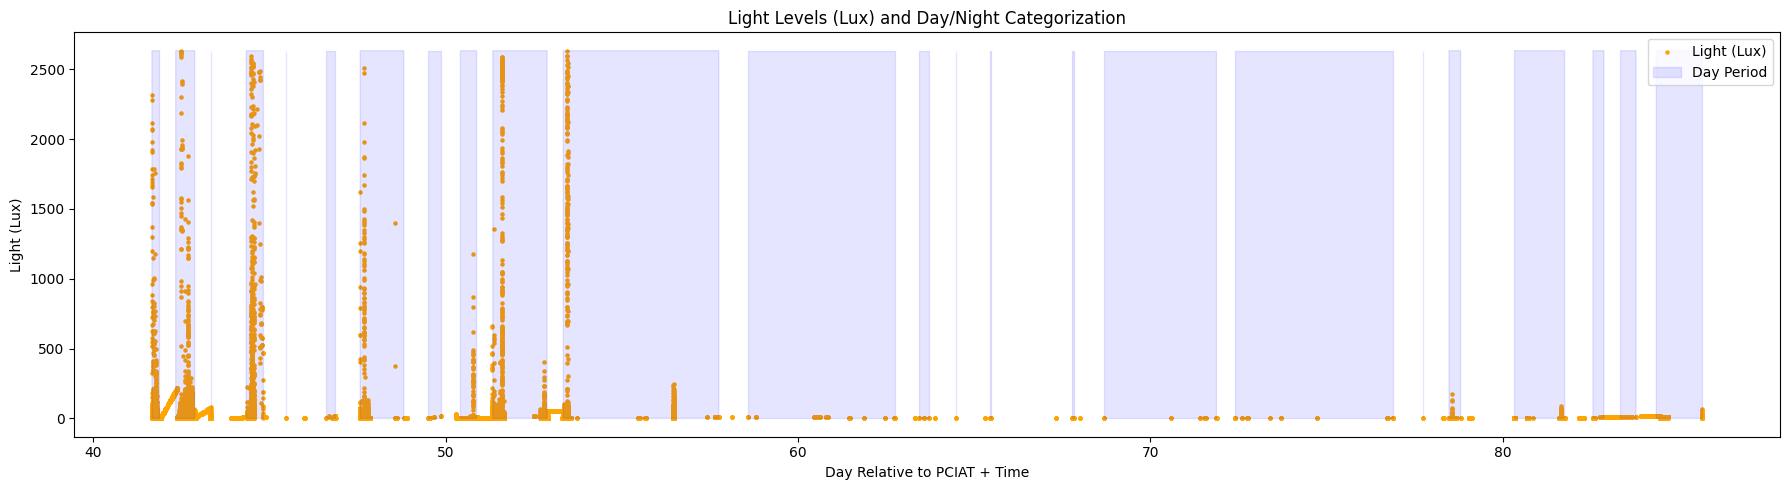

In [15]:
plt.figure(figsize=(18, 5))

plt.scatter(series_train['day_time'], series_train['light'], label='Light (Lux)', 
         color='orange', s=5)

plt.fill_between(series_train['day_time'],
                 0, series_train['light'].max(),
                 where=(series_train['day_period'] == 'day'),
                 color='blue', alpha=0.1, label='Day Period')

plt.title('Light Levels (Lux) and Day/Night Categorization')
plt.ylabel('Light (Lux)')
plt.xlabel('Day Relative to PCIAT + Time')
plt.legend()

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: The purple areas (representing the day period) toward the end of the timeline appear stretched and irregular, but we already know that a number of records have been cut from the data.
</div> 

# - Time difference between steps

From the description, `time_of_day` should represent the start of a 5s window over which the data was sampled. But in the plots above, we saw that time periods can be irregular. Let's check this out.

In [16]:
expected_diff = 5

series_train['time_diff'] = (series_train['day_time'].diff() * 86400).round(0) # seconds in a day
series_train['measurement_after_gap'] = series_train['time_diff'] > expected_diff
series_train['measurement_after_gap'].value_counts()

measurement_after_gap
False    41722
True      1608
Name: count, dtype: int64

5417 readings for this participant are off by more than 5 seconds.

In [17]:
series_train['time_diff'].describe()

count     43329.000000
mean         87.754506
std        2368.789030
min           5.000000
25%           5.000000
50%           5.000000
75%           5.000000
max      171405.000000
Name: time_diff, dtype: float64

In [18]:
156445 / 60 / 60 # sec to hours

43.45694444444444

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: There are many time gaps >5s and the maximum time gap between measurements is 43 hours.
</div> 

<div style="width: 100%; display: flex; justify-content: space-between; 
            align-items: center; padding: 10px 0; background-color: #fff;">
    <img src="https://img.icons8.com/?size=100&id=37042&format=png&color=000000" 
         alt="Flower" style="transform: scaleX(-1); margin: 0 10px;">
    <img src="https://img.icons8.com/?size=100&id=18052&format=png&color=000000" 
         alt="Flower" style="margin: 0 10px;">
    <img src="https://img.icons8.com/?size=100&id=16036&format=png&color=000000" 
         alt="Flower" style="transform: scaleX(-1); margin: 0 10px;">
</div>

# Main Statistics for all Participants

Here I calculate the percentage of rows with wear flag = 1 (device not worn) and the main statistics for key parameters for periods when the device was worn, ignoring time gaps, to get an idea of the values distributions.

In [19]:
DIR = '/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet'

def process_file(file_path, participant_id):
    data = pd.read_parquet(file_path)
    non_wear_percentage = (data['non-wear_flag'].sum() / len(data)) * 100
    worn_data = data[data['non-wear_flag'] == 0]

    return {
        'id': participant_id,
        'non_wear_percentage': non_wear_percentage,
        'enmo_stats': worn_data['enmo'].describe(),
        'anglez_stats': worn_data['anglez'].describe(),
        'light_stats': worn_data['light'].describe(),
        'battery_voltage_stats': worn_data['battery_voltage'].describe(),
        'unique_days': worn_data['relative_date_PCIAT'].nunique()
    }

results = []
for participant_id in os.listdir(DIR):
    file_path = os.path.join(DIR, participant_id, 'part-0.parquet')
    result = process_file(file_path, participant_id)
    results.append(result)

In [20]:
final_results = []
for result in results:
    flat_row = {
        'id': result['id'].replace('id=', ''),
        'non_wear_percentage': result['non_wear_percentage'],
        'unique_days': result['unique_days']
    }
    
    for key, stats in result.items():
        if isinstance(stats, pd.Series):
            for stat_name, stat_value in stats.items():
                flat_row[f'{key.replace("_stats", "")}_{stat_name}'] = stat_value
    
    final_results.append(flat_row)
    
stats_df = pd.DataFrame(final_results)
stats_df

,id,non_wear_percentage,unique_days,enmo_count,enmo_mean,enmo_std,enmo_min,enmo_25%,enmo_50%,enmo_75%,...,light_75%,light_max,battery_voltage_count,battery_voltage_mean,battery_voltage_std,battery_voltage_min,battery_voltage_25%,battery_voltage_50%,battery_voltage_75%,battery_voltage_max
0,00115b9f,0.000000,40,43330.0,0.047388,0.106351,0.0,0.006432,0.023637,0.041420,...,15.000000,2633.250000,43330.0,4053.579102,112.404045,3824.000000,4028.666748,4070.0,4147.0,4188.5
1,001f3379,65.570793,24,129316.0,0.016461,0.040610,0.0,0.000845,0.006559,0.015562,...,10.533334,2597.800049,129316.0,3984.540039,153.086365,3098.166748,3947.000000,4000.0,4076.0,4175.0


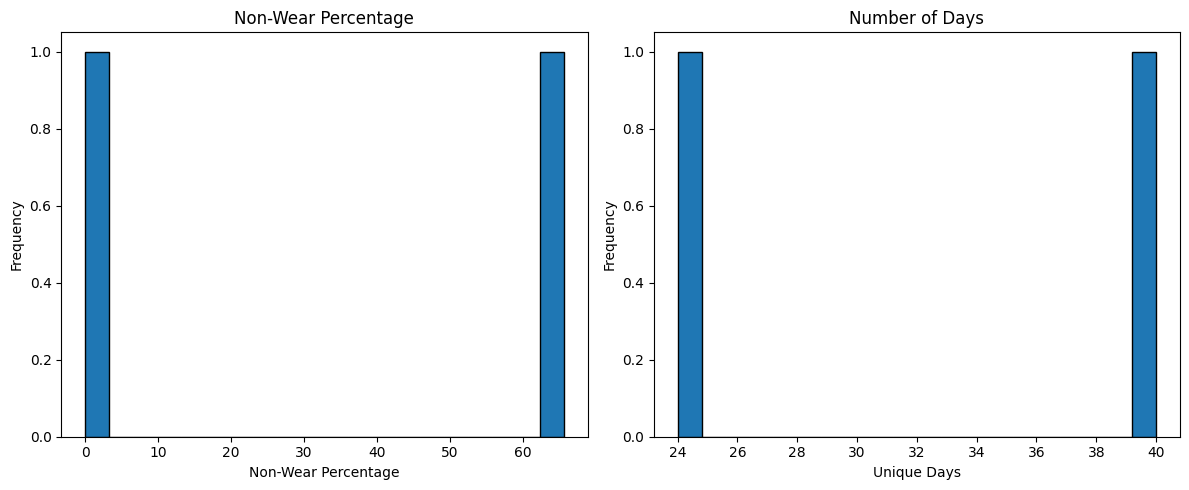

In [21]:
# non_wear_percentage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(stats_df['non_wear_percentage'], bins=20, edgecolor='black')
plt.title('Non-Wear Percentage')
plt.xlabel('Non-Wear Percentage')
plt.ylabel('Frequency')

# unique_days
plt.subplot(1, 2, 2)
plt.hist(stats_df['unique_days'], bins=20, edgecolor='black')
plt.title('Number of Days')
plt.xlabel('Unique Days')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [22]:
stats_df[['non_wear_percentage', 'unique_days']].describe()

,non_wear_percentage,unique_days
count,2.000000,2.000000
mean,32.785396,32.000000
std,46.365552,11.313708
min,0.000000,24.000000
25%,16.392698,28.000000
50%,32.785396,32.000000
75%,49.178095,36.000000
max,65.570793,40.000000


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
        <li>In total we have actigraphy data for 996 participants
        <li>The description says that "During their participation in the HBN study, some participants were given an accelerometer to wear for up to 30 days continually while at home and going about their regular daily lives", but we can see that participants actually wore the device from 1 to 81 days. Half of them wore it for 24 days or less.
    </ul>
</div>

Let's make simple plots to get a general overview of the variability in min, max, median, and std across the parameters (enmo, anglez, light, and battery_voltage)

In [23]:
def plot_parameter_statistics(stats_df, parameter):
    stats_to_plot = ['min', 'max', '50%', 'std']
    stat_labels = ['Min', 'Max', 'Median', 'Std']

    plt.figure(figsize=(14, 5))

    for j, stat in enumerate(stats_to_plot):
        plt.subplot(1, 4, j + 1)
        
        data = stats_df[f'{parameter}_{stat}']
        plt.hist(data, bins=20, alpha=0.7, edgecolor='black')
        
        plt.title(f'{parameter.capitalize()} - {stat_labels[j]}')
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

### ENMO

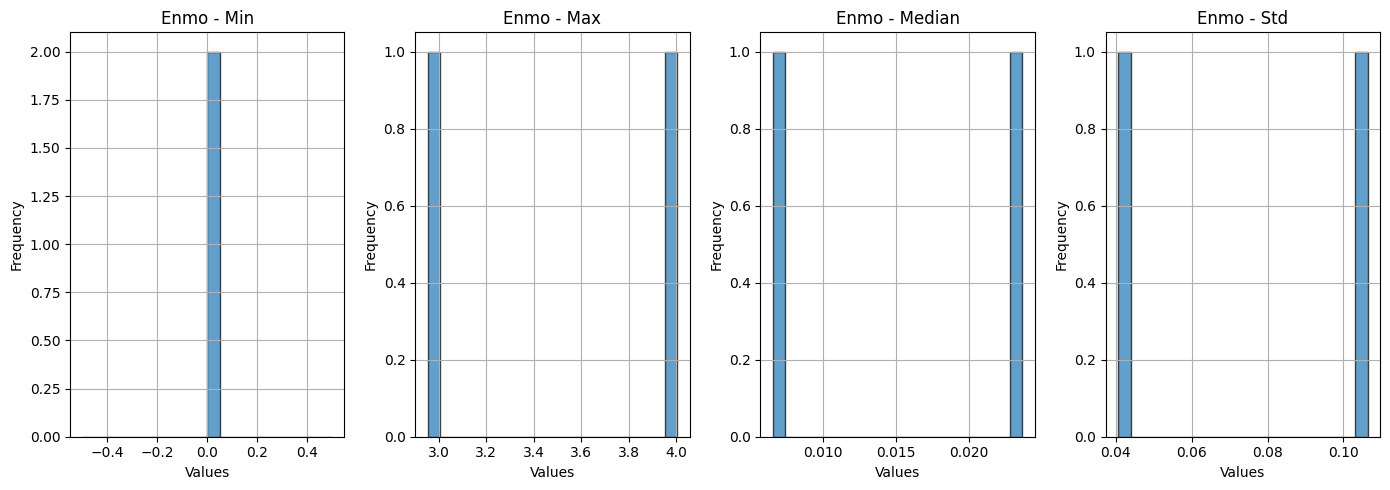

In [24]:
plot_parameter_statistics(stats_df, 'enmo')

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>There are participants without no movement periods because the minimum value can be non-zero.
<li>Most max values are between 2 and 6, but some go up to 10 or more, and apparently there are participants not moving at all? (as max can be around 0) 
    </ul>
</div>

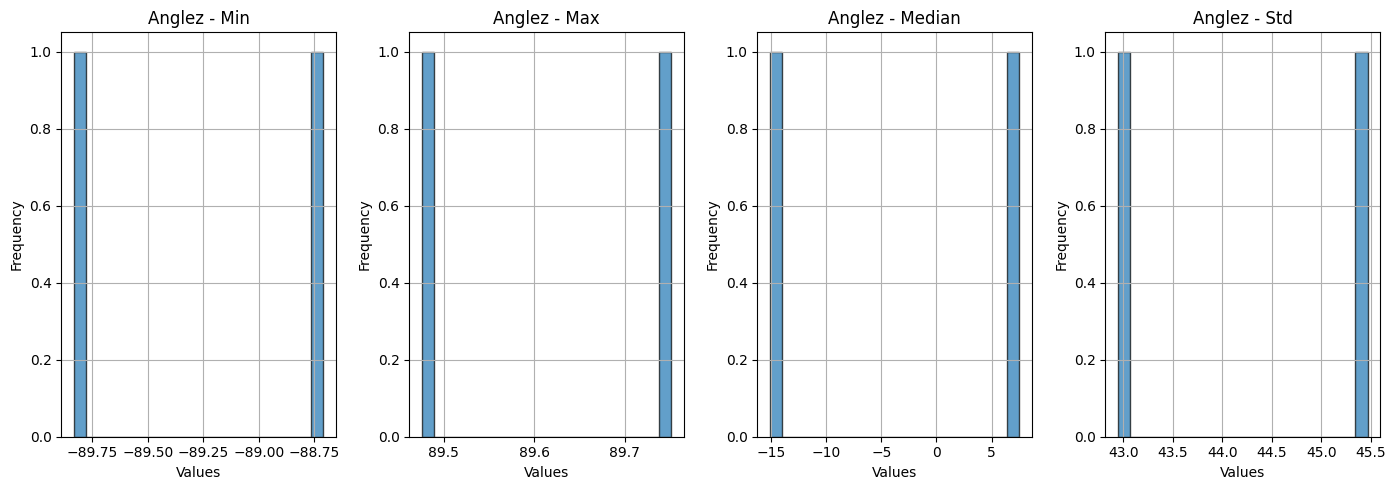

In [25]:
plot_parameter_statistics(stats_df, 'anglez')

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>Angle Z in actigraphy generally measures the vertical orientation or tilt of the wrist along the z-axis, which is typically aligned with the forearm’s longitudinal axis. Given that the device is fixed to the wrist, this angle provides information on how the wrist is rotated vertically (up or down).
<li>I think, these results make sense considering normal wrist movements throughout the day.
    </ul>
</div>

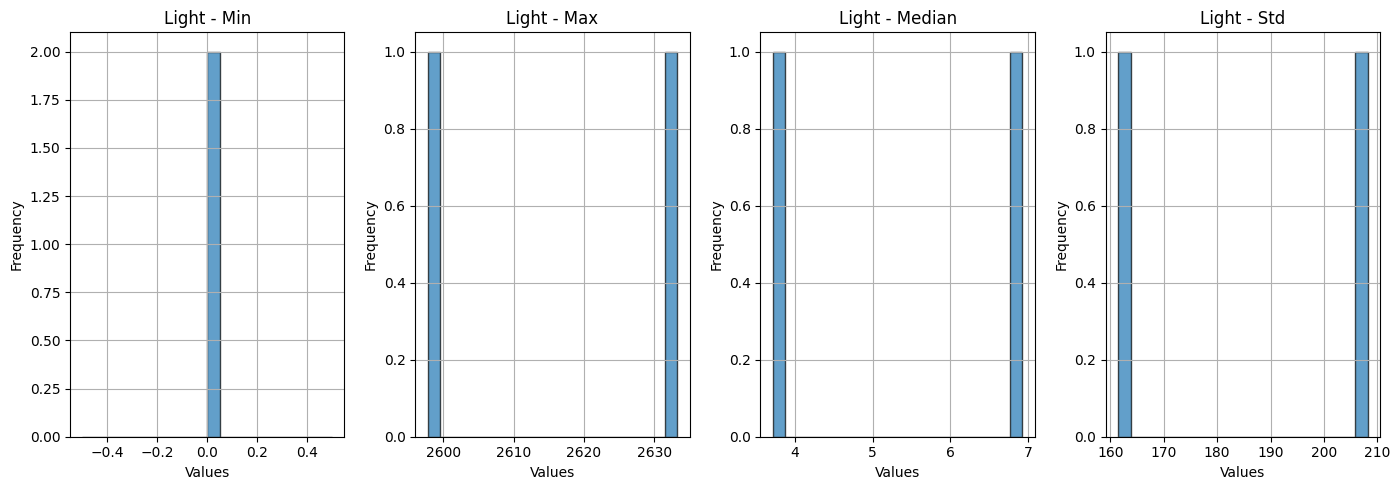

In [26]:
plot_parameter_statistics(stats_df, 'light')

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>All minimum values are at or very close to 0, which indicates that during each period of observation, the device experienced moments with no or minimal light exposure
<li>Most of the max values are concentrated between 0-2500 lux, and as with ENMO, it seems that there are participants who live in total darkness? also a few have very high values (up to around 20,000), I guess because they have a device with a higher lux range.
<li>During most recording periods, the median light exposure is low (e.g., indoors, shaded areas), but also is highly variable within samples.
    </ul>
</div>

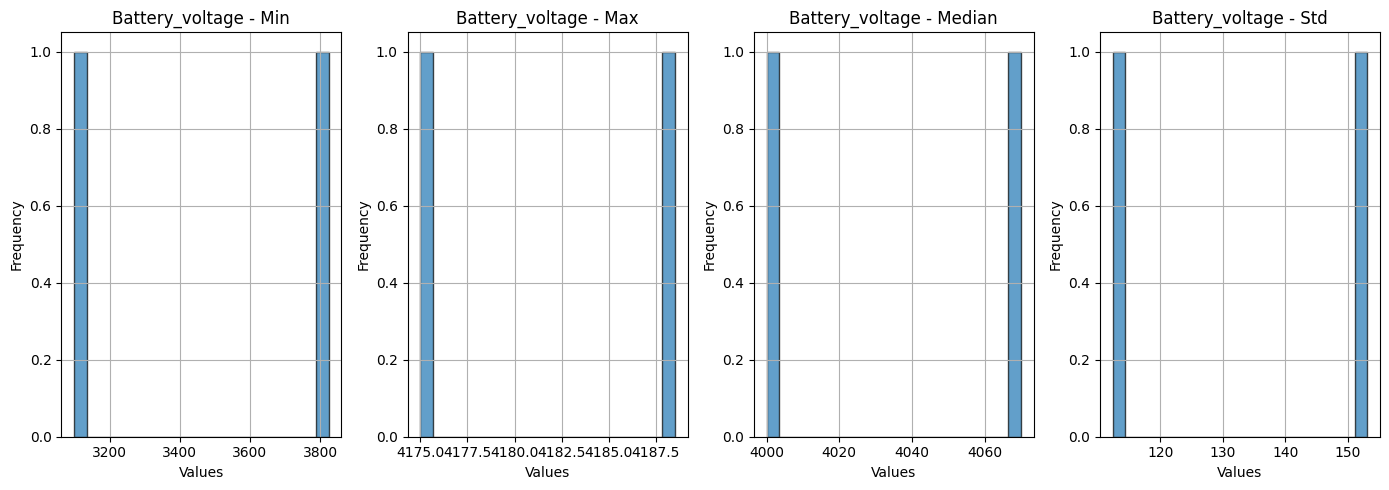

In [27]:
plot_parameter_statistics(stats_df, 'battery_voltage')

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>I did not find in the competition description which accelerometer models were given to the participants, so I referred to <a href="https://dl.theactigraph.com/GT3Xp_wGT3Xp_Device_Manual.pdf"> the ActiGraph device manual</a>, which says that all ActiGraph devices use a lithium-ion rechargeable battery with a maximum voltage of approximately 4.20 volts. At 3.1 volts the devices go into a low voltage mode (HALT mode).
<li>A significant number of devices have a minimum voltage around or below the HALT threshold (3.1V), suggesting that they experienced critically low battery levels at some point, potentially risking data collection interruptions.
    </ul>
</div>

### Save the aggregated features

In [28]:
stats_df['n_records'] = stats_df['enmo_count']
stats_df = stats_df.loc[:, ~stats_df.columns.str.endswith('_count')]
stats_df.to_csv('stats_test.csv', index=False)

<div style="width: 100%; display: flex; justify-content: space-between; 
            align-items: center; padding: 10px 0; background-color: #fff;">
    <img src="https://img.icons8.com/?size=100&id=xrQnyagkvVrx&format=png&color=000000" 
         alt="Flower" style="transform: scaleX(-1); margin: 0 10px;">
    <img src="https://img.icons8.com/?size=100&id=tKXc9FB10998&format=png&color=000000" 
         alt="Flower" style="margin: 0 10px;">
    <img src="https://img.icons8.com/?size=100&id=h38xtI5GG8cD&format=png&color=000000" 
         alt="Flower" style="transform: scaleX(-1); margin: 0 10px;">
</div>

Below, I explore several key aspects of actigraphy data to derive meaningful insights for feature engineering using only measurements when the device was worn according to the `non-wear_flag` column.

Some of the articles I referred to:
- [Accelerometer assessed moderate-to-vigorous physical activity and successful ageing: results from the Whitehall II study](https://www.nature.com/articles/srep45772)
- [Intensity Thresholds on Raw Acceleration Data: Euclidean Norm Minus One (ENMO) and Mean Amplitude Deviation (MAD) Approaches](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0164045)

In [29]:
worn_data = series_train[series_train['non-wear_flag'] == 0]

# recalculate time difference between rows and measurement_after_gap flag
worn_data['time_diff'] = (worn_data['day_time'].diff() * 86400).round(0)
worn_data['measurement_after_gap'] = worn_data['time_diff'] > expected_diff
worn_data['measurement_after_gap'].value_counts()

measurement_after_gap
False    41722
True      1608
Name: count, dtype: int64

# No motion periods

Zero values are indicative of periods of no motion in the `enmo` column. Let's see if there are any for our participant and how long they lasted.

In [30]:
worn_data[worn_data['enmo'] == 0]

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,time_of_day_hours,day_time,day_period,time_diff,measurement_after_gap
61,61,-0.893880,0.107292,0.370937,0.0,22.422384,0.0,3.100000,4181.0,57555000000000,4,3,41.0,15.987500,41.666146,day,5.0,False
66,66,-0.690547,0.040729,0.673177,0.0,44.263309,0.0,7.433333,4181.0,57580000000000,4,3,41.0,15.994444,41.666435,day,5.0,False
245,245,-0.571458,-0.361120,-0.705521,0.0,-46.285225,0.0,42.750000,4181.0,58475000000000,4,3,41.0,16.243056,41.676794,day,5.0,False
246,246,-0.583802,-0.343203,-0.703828,0.0,-46.088989,0.0,29.000000,4181.0,58480000000000,4,3,41.0,16.244444,41.676852,day,5.0,False
247,247,-0.583516,-0.347813,-0.702422,0.0,-45.980530,0.0,33.400002,4181.0,58485000000000,4,3,41.0,16.245833,41.676910,day,5.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43228,43228,-0.317839,0.089844,0.926641,0.0,70.421471,0.0,10.931061,3829.0,59665000000000,5,3,84.0,16.573611,84.690567,day,5.0,False
43229,43229,-0.318229,0.089670,0.926215,0.0,70.296303,0.0,10.933818,3829.0,59670000000000,5,3,84.0,16.575000,84.690625,day,5.0,False
43236,43236,-0.286302,0.029870,0.938516,0.0,73.006866,0.0,2.148148,3829.0,59820000000000,5,3,84.0,16.616667,84.692361,day,5.0,False
43238,43238,-0.254870,0.036901,0.950130,0.0,74.886978,0.0,5.907407,3829.0,59855000000000,5,3,84.0,16.626389,84.692766,day,5.0,False


To calculate the duration of periods of no motion, we need to account for time gaps between records, e.g., treat such gaps as breaks in continuous data collection.
Next, group consecutive periods of no motion by groupping rows with consecutive zeros in `enmo`

In [31]:
no_motion = worn_data['enmo'] == 0

motion_group = (
    (no_motion != no_motion.shift()) |
    (worn_data['measurement_after_gap'])
).cumsum()

no_motion_periods = worn_data[no_motion].groupby(
    motion_group
)['day_time'].agg(['min', 'max'])

no_motion_periods['duration_sec'] = (
    (no_motion_periods['max'] - no_motion_periods['min']) * 86400
).round(0).astype(int)

print(f"Min duration in seconds: {no_motion_periods['duration_sec'].min()}")
print(f"Max duration in seconds: {no_motion_periods['duration_sec'].max()}")

Min duration in seconds: 0
Max duration in seconds: 85


A duration of 0 seconds results from single records surrounded by periods of motion. Given that the time column in the data represents the start of a 5 second window over which the data is sampled, it is reasonable to assume that such single period records have a duration of 5 seconds and add 5 seconds to all durations.

In [32]:
no_motion_periods['duration_sec'] += 5

print("Total duration in hours:", no_motion_periods['duration_sec'].sum() / 3600)
no_motion_periods.sort_values(by='duration_sec')

Total duration in hours: 3.5708333333333333


,min,max,duration_sec
5,41.666146,41.666146,5
2895,53.437731,53.437731,5
1301,44.311574,44.311574,5
2882,53.430671,53.430671,5
1312,44.320255,44.320255,5
...,...,...,...
61,41.734896,41.735417,50
2321,51.577894,51.578414,50
1178,43.327488,43.328067,55
2295,51.505613,51.506192,55


There are 3034 periods of no movement, ranging from 0 (a single record surrounded by periods of movement) to 110 seconds, or 7.6 hours of no movement during the entire time the device was worn.

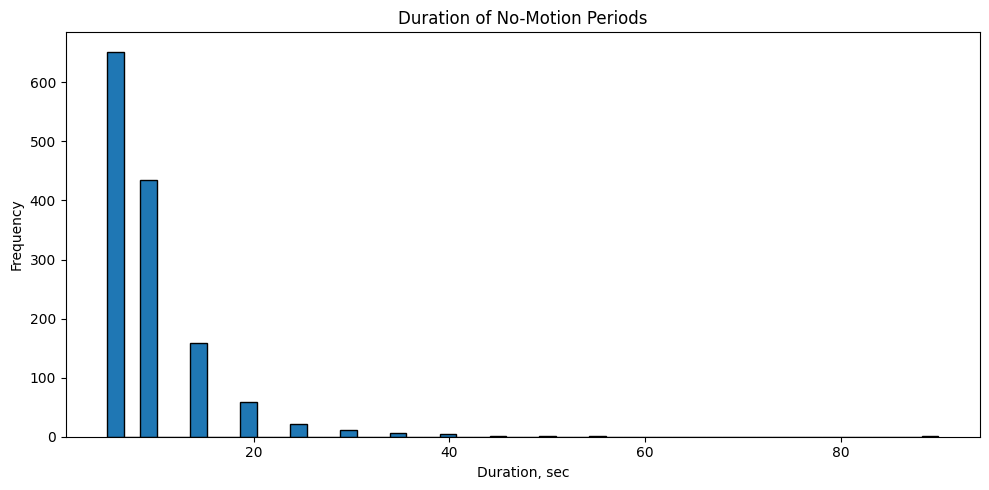

In [33]:
plt.figure(figsize=(10, 5))

plt.hist(no_motion_periods.loc[:, 'duration_sec'],
         bins=50, edgecolor='black')
plt.xlabel('Duration, sec')
plt.ylabel('Frequency')
plt.title('Duration of No-Motion Periods')

plt.tight_layout()
plt.show()

In [34]:
bins = [0, 15, 30, 60, 120]
no_motion_periods['duration_bin'] = pd.cut(no_motion_periods['duration_sec'], bins)
period_counts = no_motion_periods['duration_bin'].value_counts().sort_index()
period_counts

duration_bin
(0, 15]      1245
(15, 30]       91
(30, 60]       18
(60, 120]       1
Name: count, dtype: int64

The majority of the no-motion periods lasted less than 30 sec. Now let's plot the frequency of no motion by time of the day.

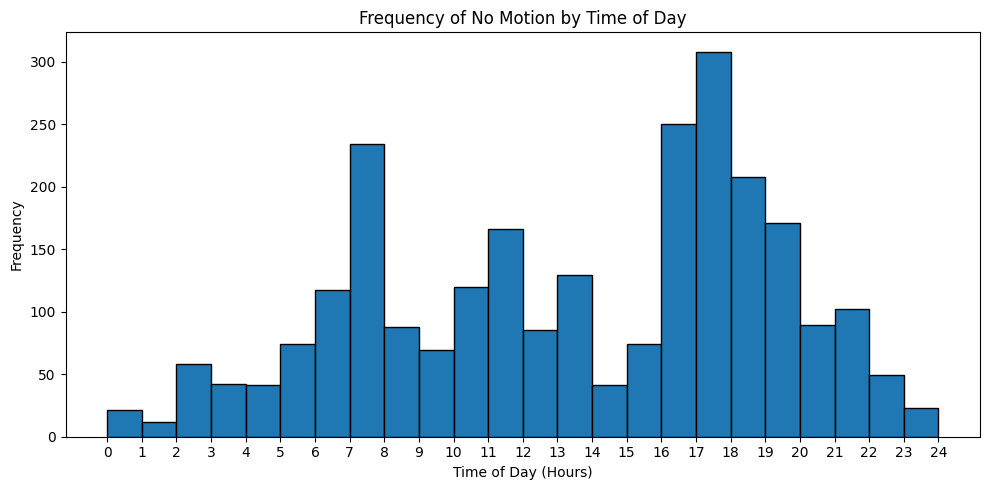

In [35]:
plt.figure(figsize=(10, 5))
plt.hist(worn_data[no_motion]['time_of_day_hours'],
         bins=24, range=(0, 24), edgecolor='black')
plt.title('Frequency of No Motion by Time of Day')
plt.xlabel('Time of Day (Hours)')
plt.ylabel('Frequency')
plt.xticks(range(0, 25))
plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: This distribution appears consistent with a typical day cycle where activity is lower at night and early morning (sleep) - more no motion periods, increases during the day (wakefulness) - less no motion periods, and then decreases again in the evening and night - a bit more no motion periods after 5 pm. I think no motion data (e.g. mean, max, or sdt) can be used as a feature.
</div>
 

Let's visually assess the stability of no-motion periodds for the participant

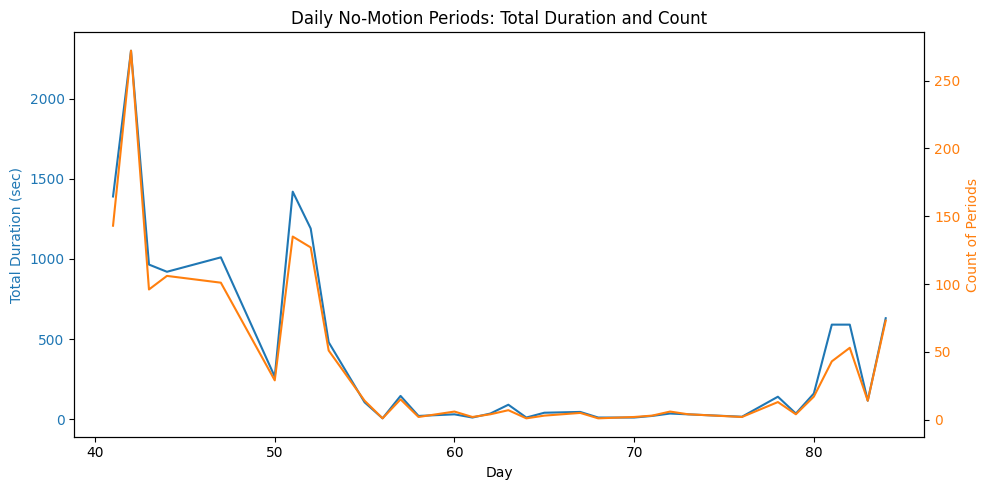

In [36]:
no_motion_periods['day'] = no_motion_periods['min'].astype(int)

daily_stats = no_motion_periods.groupby(no_motion_periods['day']) \
    .agg(total_duration=('duration_sec', 'sum'),
         count_periods=('duration_sec', 'size'))


fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Day')
ax1.set_ylabel('Total Duration (sec)', color=color)
ax1.plot(daily_stats.index, daily_stats['total_duration'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Count of Periods', color=color)
ax2.plot(daily_stats.index, daily_stats['count_periods'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Daily No-Motion Periods: Total Duration and Count')
fig.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>There is a high fluctuation in both the total duration and count of no-motion periods in the first half (around days 1-30). This suggests inconsistent no-motion periods, potentially due to varying activity patterns or different recording conditions.
<li>Around day 35, there is a sharp decline in both metrics, consistent with the numerous interruptions in recording noted above.
<li>Days with more no-motion periods also have longer cumulative durations, so if this is true for all participants, it makes sense to keep only one of them as a feature.
<li>The no-motion feature is heavily influenced by day-to-day changes or device usage patterns
    </ul>
</div>

# - Ideas for feature engeneering

To account for the variation in wearing durations across participants, we must calculate relative values by normalizing against the total duration of wearing the device (e.g., days). 

Aggregated  (mean, median, max, std) across days:
- Total duration of no motion per day
- Count of no-motion periods per day

Example of aggregated features calculation:

In [37]:
features = daily_stats[['total_duration', 'count_periods']].agg(
    ['median', 'max', 'std']
).T.unstack().to_frame().T

features.columns = ['_'.join(col) for col in features.columns]

features

,median_total_duration,median_count_periods,max_total_duration,max_count_periods,std_total_duration,std_count_periods
0,105.0,13.0,2300.0,272.0,557.549554,60.863032


# Circadian Rhythm Analysis

Group the activity data by hour of the day and plot the average activity (ENMO) across the 24-hour day.

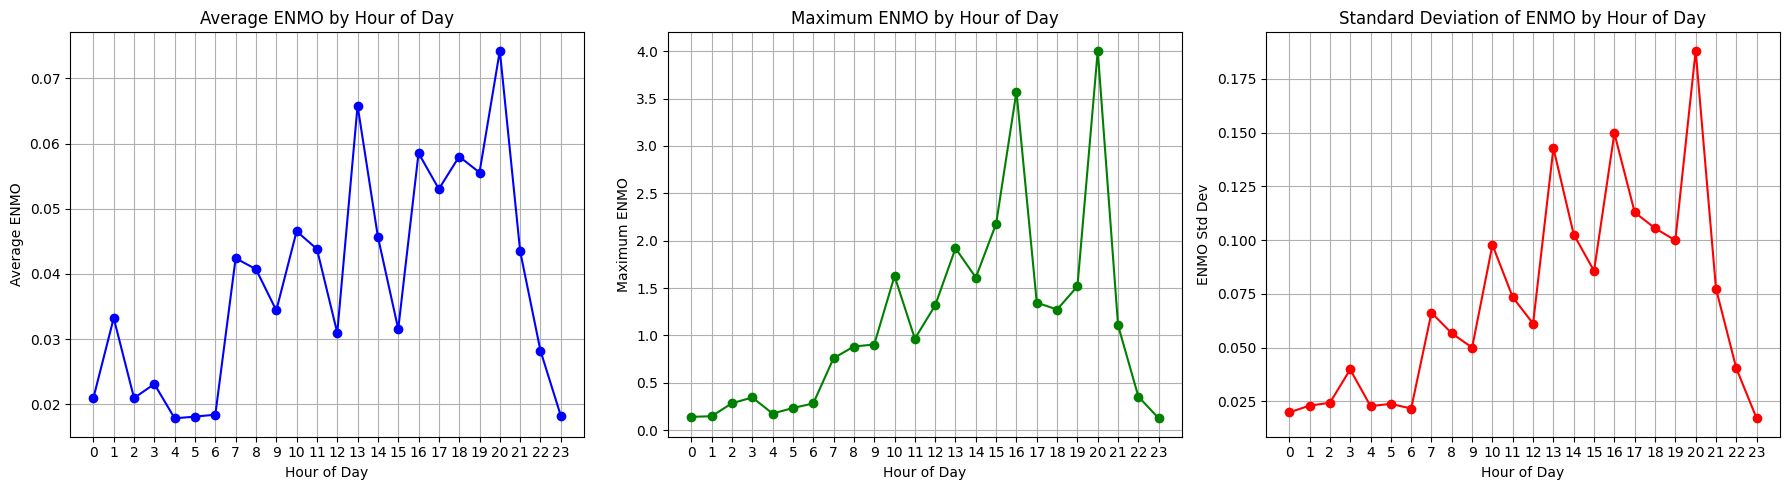

In [38]:
hourly_activity = worn_data.groupby(
    worn_data['time_of_day_hours'].astype(int)
)['enmo'].agg(['mean', 'max', 'std'])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# average ENMO
axes[0].plot(hourly_activity.index, hourly_activity['mean'], marker='o', color='blue')
axes[0].set_xticks(hourly_activity.index)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average ENMO')
axes[0].set_title('Average ENMO by Hour of Day')
axes[0].grid(True)

# maximum ENMO
axes[1].plot(hourly_activity.index, hourly_activity['max'], marker='o', color='green')
axes[1].set_xticks(hourly_activity.index)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Maximum ENMO')
axes[1].set_title('Maximum ENMO by Hour of Day')
axes[1].grid(True)

# standard deviation of ENMO
axes[2].plot(hourly_activity.index, hourly_activity['std'], marker='o', color='red')
axes[2].set_xticks(hourly_activity.index)
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylabel('ENMO Std Dev')
axes[2].set_title('Standard Deviation of ENMO by Hour of Day')
axes[2].grid(True)

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
        <li>Seems this way we can get sleep and wake times as features
        <li>Here the sleep time seems to be about 6 hours, quite a little for a 6 year old child
    </ul>
</div>

# - Ideas for feature engeneering

Here we can make features capturing the variation in activity across the 24-hour cycle, separately for day and night times (or wakefulness and sleep periods). It can be useful to calculate features from both average and maximum hourly activity, as they provide different insights: the overall behaviour during each hour and the peak or most extreme activity during each hour. Here i go with mean enmo values.

Aggregated  (mean, median, max, std):
- Standard deviation across hourly means per day (captures how different each hour is from the rest)
- The hour with the highest activity
- Entropy of the distribution across hours (how evenly the activity is distributed throughout the day)

In [39]:
hourly_activity = worn_data.groupby(
    [worn_data['relative_date_PCIAT'].astype(int),
     worn_data['time_of_day_hours'].astype(int),
     worn_data['day_period']]
)['enmo'].agg(['mean', 'max'])

features = hourly_activity['mean'].groupby(
    ['relative_date_PCIAT', 'day_period']
).agg(
    std_across_hours='std',
    peak_hour=lambda x: x.idxmax()[1],
    entropy=lambda x: -(x / x.sum() * np.log(x / x.sum() + 1e-9)).sum()
)

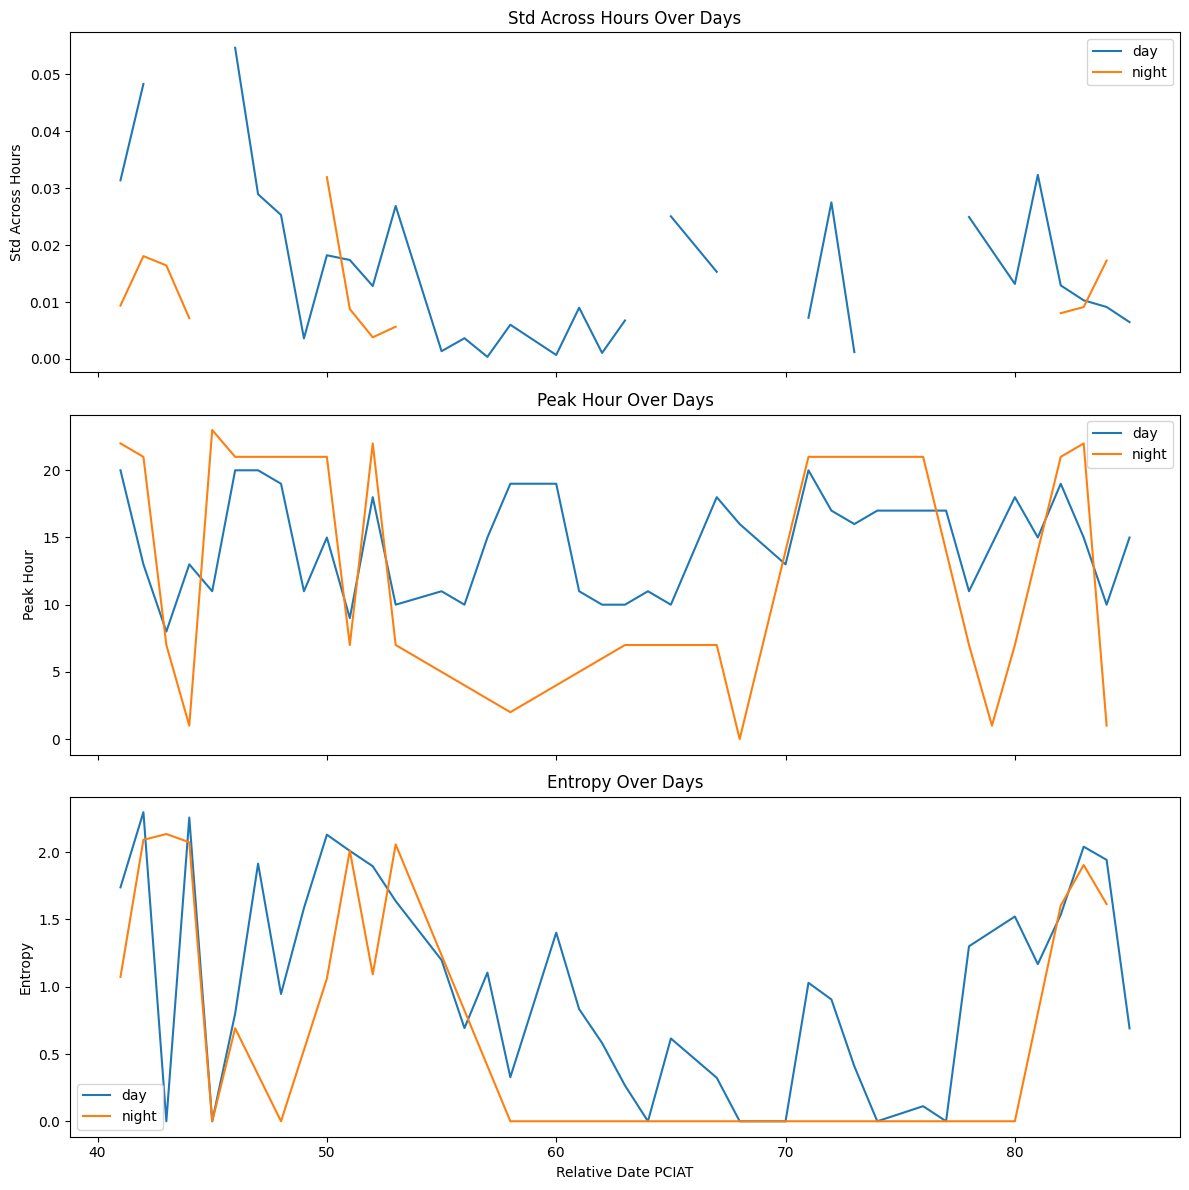

In [40]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot std_across_hours
for period in ['day', 'night']:
    subset = features.xs(period, level='day_period')
    axes[0].plot(subset.index, subset['std_across_hours'], label=period)

axes[0].set_title('Std Across Hours Over Days')
axes[0].set_ylabel('Std Across Hours')
axes[0].legend()

# Plot peak_hour
for period in ['day', 'night']:
    subset = features.xs(period, level='day_period')
    axes[1].plot(subset.index, subset['peak_hour'], label=period)

axes[1].set_title('Peak Hour Over Days')
axes[1].set_ylabel('Peak Hour')
axes[1].legend()

# Plot entropy
for period in ['day', 'night']:
    subset = features.xs(period, level='day_period')
    axes[2].plot(subset.index, subset['entropy'], label=period)

axes[2].set_title('Entropy Over Days')
axes[2].set_xlabel('Relative Date PCIAT')
axes[2].set_ylabel('Entropy')
axes[2].legend()

plt.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>The hourly standard deviation of ENMO values is generally higher during the day (blue line) compared to the night (orange line). This indicates more variability in movement during the day. 
<li>The day peak hours (blue line) fluctuate considerably, while night peak hours (orange line) mostly remain later in the evening or early morning
<li>The distribution of ENMO values across hours (entropy) is generally higher for day than for night.
<li>A clear distinction in movement patterns between day and night, with some fluctuations indicating variability in daily activity patterns
    </ul>
</div>

In [41]:
day_features = features.xs('day', level='day_period').agg(
    ['median', 'max', 'std']
).stack().to_frame().T
day_features.columns = [
    f'{stat}_{feature}_day' for stat, feature in day_features.columns
]

night_features = features.xs('night', level='day_period').agg(
    ['median', 'max', 'std']
).stack().to_frame().T
night_features.columns = [
    f'{stat}_{feature}_night' for stat, feature in night_features.columns
]

features = pd.concat([day_features, night_features], axis=1)
features

,median_std_across_hours_day,median_peak_hour_day,median_entropy_day,max_std_across_hours_day,max_peak_hour_day,max_entropy_day,std_std_across_hours_day,std_peak_hour_day,std_entropy_day,median_std_across_hours_night,median_peak_hour_night,median_entropy_night,max_std_across_hours_night,max_peak_hour_night,max_entropy_night,std_std_across_hours_night,std_peak_hour_night,std_entropy_night
0,0.013048,15.0,0.946012,0.054668,20.0,2.297592,0.013903,3.782551,0.752829,0.009248,7.0,0.345751,0.051025,23.0,2.135219,0.01312,8.825913,0.898709


# Physical Activity Analysis

Analyze the Moderate to Vigorous Physical Activity (MVPA) based on a threshold of ENMO values, and calculate the duration of the detected MVPA activity bouts. To avoid over-segmentation of MVPA bouts, where brief interruptions or noise may break up continuous periods of activity, we can introduce a smoothing mechanism. This ensures that short interruptions in MVPA do not split the bouts into separate periods.

In [42]:
# Example smoothing method

window_size = 12  # Rolling window size in rows (equal to 60 s)

def rolling_average_per_segment(df, window_size):
    return df['enmo'].rolling(window=window_size, min_periods=1).mean()

segment_group = worn_data['measurement_after_gap'].cumsum()

worn_data['smoothed_enmo'] = worn_data.groupby(segment_group)['enmo'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

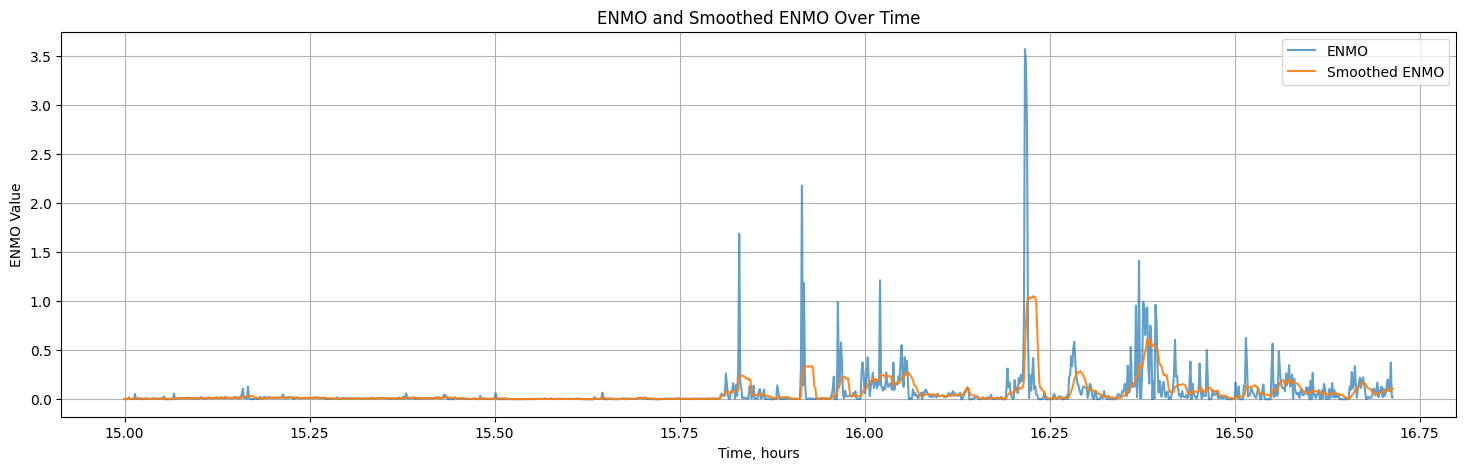

In [43]:
show_day = 2 # show second day
hour_from = 15
hour_to = 17

show_day = min(worn_data['relative_date_PCIAT']) + show_day - 1
filtered_data = worn_data[
    (worn_data['relative_date_PCIAT'] == show_day) &
    (worn_data['time_of_day_hours'] >= hour_from) & 
    (worn_data['time_of_day_hours'] < hour_to)
].copy()

plt.figure(figsize=(18, 5))
plt.plot(
    filtered_data['time_of_day_hours'],
    filtered_data['enmo'],
    label='ENMO', alpha=0.7)
plt.plot(
    filtered_data['time_of_day_hours'],
    filtered_data['smoothed_enmo'],
    label='Smoothed ENMO', alpha=0.9
)
plt.xlabel('Time, hours')
plt.ylabel('ENMO Value')
plt.title('ENMO and Smoothed ENMO Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
worn_data.drop('smoothed_enmo', axis=1, inplace=True)

As in the aforementioned article, in order to classify physical activity as MVPA, I only retained activities that lasted at least 1 minute and met the criteria for the 100 mg (= 0.1g) threshold. But first I merge MVPA episodes that are less than 60 seconds apart. Example with dummy data:

In [45]:
mvpa_threshold = 0.1
merge_gap = 60

In [46]:
data = {
    'day_time': [
        1.00011574, 1.00023148, 1.00034722, 1.00046296, 1.00113426, 
         1.00125000, 1.00136574, 1.00148148, 1.00159722, 2.00023148
    ],
    'enmo': [0.05, 0.12, 0.11, 0.08, 0.15, 0.12, 0.09, 0.08, 0.15, 0.2]
}
data = pd.DataFrame(data)
data['time_diff'] = (data['day_time'].diff() * 86400).round(0)
data['is_mvpa'] = data['enmo'] > mvpa_threshold

data['mvpa_group'] = (
    (data['is_mvpa'] != data['is_mvpa'].shift()) |
    (data['time_diff'] >= merge_gap)
).cumsum()

data['is_mvpa_start'] = (
    (data['mvpa_group'] != data['mvpa_group'].shift()) &
    data['is_mvpa']
)

data['last_mvpa_time'] = data['day_time'].where(data['is_mvpa']).ffill().shift()
data['mvpa_time_diff'] = ((data['day_time'] - data['last_mvpa_time']) * 86400).round(0)
data['group_increment'] = data['is_mvpa_start'] & (
    (data['mvpa_time_diff'] >= merge_gap) | data['last_mvpa_time'].isnull()
)
data['group_increment'] = data['group_increment'].astype(int)
data['merged_group'] = data['group_increment'].cumsum()
data.loc[~data['is_mvpa'], 'merged_group'] = np.nan
data

,day_time,enmo,time_diff,is_mvpa,mvpa_group,is_mvpa_start,last_mvpa_time,mvpa_time_diff,group_increment,merged_group
0,1.000116,0.05,NaN,False,1,False,NaN,NaN,0,NaN
1,1.000231,0.12,10.0,True,2,True,NaN,NaN,1,1.0
2,1.000347,0.11,10.0,True,2,False,1.000231,10.0,0,1.0
3,1.000463,0.08,10.0,False,3,False,1.000347,10.0,0,NaN
4,1.001134,0.15,58.0,True,4,True,1.000347,68.0,1,2.0
5,1.001250,0.12,10.0,True,4,False,1.001134,10.0,0,2.0
6,1.001366,0.09,10.0,False,5,False,1.001250,10.0,0,NaN
7,1.001481,0.08,10.0,False,5,False,1.001250,20.0,0,NaN
8,1.001597,0.15,10.0,True,6,True,1.001250,30.0,0,2.0
9,2.000231,0.20,86282.0,True,7,True,1.001597,86282.0,1,3.0


The first MVPA activity group is 2, the second is 4 and is 68 s apart, so they are not merged (the merged group numbers remain different). Groups 4 and 6 are separated by 30 s of non-MVPA activity, so they are merged into one group (merged group 2). Groups 6 and 7 are consecutive but are not merged as there is a huge time gap between them.

Let's apply to our data:

In [47]:
def merge_mvpa_groups(df, allowed_gap=60, merge_gap=60):
    last_mvpa_time = df['day_time'].where(df['is_mvpa']).ffill().shift()
    
    mvpa_time_diff = (
        (df['day_time'] - last_mvpa_time) * 86400
    ).round(0)
    
    mvpa_group = (
        (df['is_mvpa'] != df['is_mvpa'].shift()) |
        (df['time_diff'] >= allowed_gap)
    ).cumsum()
    
    is_mvpa_start = (
        (mvpa_group != mvpa_group.shift()) &
        df['is_mvpa']
    )
    
    group_increment = is_mvpa_start & (
        (mvpa_time_diff >= merge_gap) | last_mvpa_time.isnull()
    )
    
    merged_group = group_increment.cumsum()
    merged_group.loc[~df['is_mvpa']] = np.nan
    
    return merged_group

worn_data['is_mvpa'] = worn_data['enmo'] > mvpa_threshold
worn_data['mvpa_merged_group'] = merge_mvpa_groups(worn_data)

mvpa_periods = worn_data[
    worn_data['is_mvpa']
].groupby('mvpa_merged_group')['day_time'].agg(['min', 'max'])

mvpa_periods['duration_sec'] = (
    mvpa_periods['max'] - mvpa_periods['min']
) * 86400  # days to seconds

mvpa_periods = mvpa_periods[mvpa_periods['duration_sec'] >= 60]
mvpa_periods['duration_min'] = mvpa_periods['duration_sec'] / 60

mvpa_periods.sort_values(by='duration_sec')

,min,max,duration_sec,duration_min
mvpa_merged_group,,,,
258.0,44.526447,44.527141,60.0,1.000000
149.0,42.748148,42.748843,60.0,1.000000
405.0,52.730613,52.731308,60.0,1.000000
247.0,44.487616,44.488368,65.0,1.083333
362.0,51.335880,51.336632,65.0,1.083333
...,...,...,...,...
288.0,47.716377,47.724826,730.0,12.166667
214.0,43.328819,43.337269,730.0,12.166667
184.0,42.863137,42.871759,745.0,12.416667


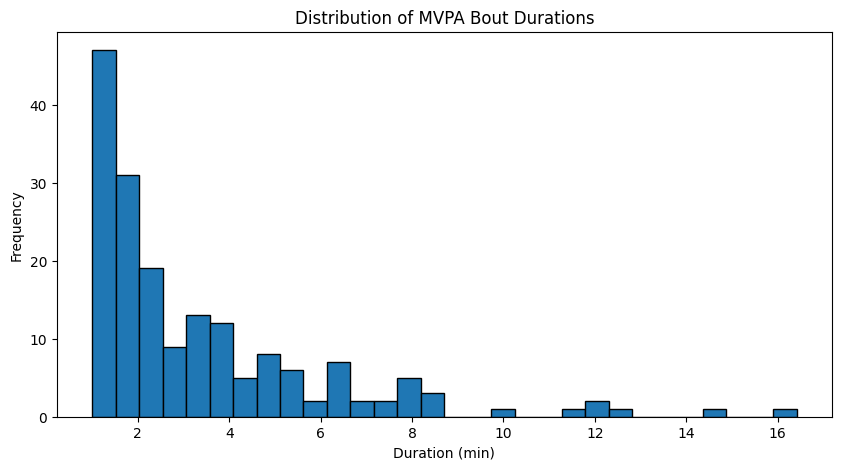

In [48]:
plt.figure(figsize=(10, 5))
plt.hist(mvpa_periods['duration_min'], bins=30, edgecolor='black')
plt.xlabel('Duration (min)')
plt.ylabel('Frequency')
plt.title('Distribution of MVPA Bout Durations')
plt.show()

In [49]:
summary_stats = mvpa_periods['duration_min'].describe()

short_mvpa_count = mvpa_periods[mvpa_periods['duration_min'] < 10].shape[0]
long_mvpa_count = mvpa_periods[mvpa_periods['duration_min'] >= 10].shape[0]

print(f"Summary Statistics:\n{summary_stats}\n")
print(f"Short MVPA periods (< 10 min): {short_mvpa_count}")
print(f"Long MVPA periods (>= 10 min): {long_mvpa_count}")

Summary Statistics:
count    178.000000
mean       3.385768
std        2.738552
min        1.000000
25%        1.500000
50%        2.291667
75%        4.354167
max       16.416667
Name: duration_min, dtype: float64

Short MVPA periods (< 10 min): 172
Long MVPA periods (>= 10 min): 6


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: I got the distribution where the majority of MVPA bouts are very short, between 0 and 10 minutes. Perhaps the thresholds need to be adjusted, and if it looks realistic, number of MVPA activity boots and their duration can also be used as a feature for modeling SII prediction.
</div>

In [50]:
worn_data.drop(['is_mvpa', 'mvpa_merged_group'], axis=1, inplace=True)

Let's visually assess the stability of MVPA periodds for the participant

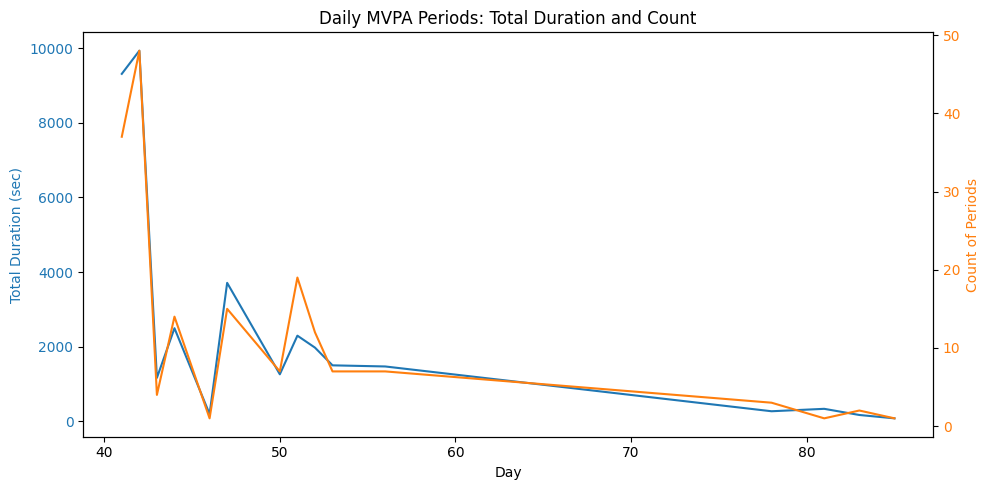

In [51]:
mvpa_periods['day'] = mvpa_periods['min'].astype(int)

daily_stats = mvpa_periods.groupby(mvpa_periods['day']) \
    .agg(total_duration=('duration_sec', 'sum'),
         count_periods=('duration_sec', 'size'))


fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Day')
ax1.set_ylabel('Total Duration (sec)', color=color)
ax1.plot(daily_stats.index, daily_stats['total_duration'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Count of Periods', color=color)
ax2.plot(daily_stats.index, daily_stats['count_periods'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Daily MVPA Periods: Total Duration and Count')
fig.tight_layout()
plt.show()

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>As wuth no motion periods, there is a high fluctuation in both the total duration and count of no-motion periods in the first half (around days 1-35).
<li>Around day 35, there is a sharp decline in both metrics, consistent with the numerous interruptions in recording noted above.
<li>If number of MVPA periods also correlate well with durations for all participants, it makes sense to keep only one of them as a feature.
<li>The MVPA features are heavily influenced by day-to-day changes or device usage patterns
    </ul>
</div>

# - Ideas for feature engeneering

Here we can make the same features as for no_motion periods:

Aggregated  (mean, median, max, std):
- Total duration of MVPA per day
- Number of MVPA bouts per day

In [52]:
features = daily_stats[['total_duration', 'count_periods']].agg(
    ['median', 'max', 'std']
).T.unstack().to_frame().T

features.columns = ['_'.join(col) for col in features.columns]

features

,median_total_duration,median_count_periods,max_total_duration,max_count_periods,std_total_duration,std_count_periods
0,1470.0,7.0,9930.0,48.0,3103.940391,13.798896


# Activity Transition Analysis

Now I extend the analysis to look at transitions between low, moderate and vigorous activity.  To smooth out sudden, short bursts of different activities, I filter out segments with a duration below a 1 minute threshold.

In [53]:
mvpa_threshold = 0.1
vig_threshold = 0.5

worn_data['activity_type'] = pd.cut(
    worn_data['enmo'],
    bins=[-np.inf, mvpa_threshold, vig_threshold, np.inf],
    labels=['low', 'moderate', 'vigorous']
)
activity_group = (
        (worn_data['activity_type'] != worn_data['activity_type'].shift()) |
        (worn_data['measurement_after_gap'])
).cumsum()

activity_periods = worn_data.groupby(activity_group).agg(
    min=('day_time', 'min'),
    max=('day_time', 'max'),
    activity_type=('activity_type', 'first')
)
activity_periods['duration_sec'] = (
    activity_periods['max'] - activity_periods['min']
) * 86400 + 5 

activity_periods = activity_periods[activity_periods['duration_sec'] >= 60]
activity_periods['duration_min'] = activity_periods['duration_sec'] / 60

activity_periods['day'] = activity_periods['min'].astype(int)
activity_periods['transition_num'] = (
    activity_periods.groupby('day')['activity_type']
    .apply(lambda x: (x != x.shift()).cumsum())
    .reset_index(level=0, drop=True)
)

activity_periods.sort_values(by='duration_sec')

,min,max,activity_type,duration_sec,duration_min,day,transition_num
4925,56.451852,56.452488,low,60.0,1.000000,56,1
4671,53.284317,53.284954,low,60.0,1.000000,53,1
2379,43.306829,43.307465,low,60.0,1.000000,43,1
4513,52.931829,52.932465,low,60.0,1.000000,52,3
5594,84.460012,84.460648,low,60.0,1.000000,84,1
...,...,...,...,...,...,...,...
5178,78.568924,78.595197,low,2275.0,37.916667,78,1
4733,53.380903,53.407465,low,2300.0,38.333333,53,1
3993,51.444502,51.478704,low,2960.0,49.333333,51,1
4212,52.669618,52.708912,low,3400.0,56.666667,52,1


In [54]:
max(activity_periods['transition_num'])

3

In [55]:
activity_periods[activity_periods['activity_type'] == 'vigorous']

,min,max,activity_type,duration_sec,duration_min,day,transition_num


In [56]:
summary_table = pd.DataFrame({
    'Number of Periods': activity_periods['activity_type'].value_counts(),
    'Total Duration (min)': activity_periods.groupby(
        'activity_type', observed=False
    )['duration_min'].sum()
}).reset_index()

summary_table.rename(columns={'index': 'Activity Type'}, inplace=True)
summary_table

,activity_type,Number of Periods,Total Duration (min)
0,low,616,2294.750000
1,moderate,7,9.583333
2,vigorous,0,0.000000


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: Most of the recorded activity was classified as low intensity, with very few periods classified as moderate, and one 1-min spike as vigorous
</div>

Visualize changes across days:

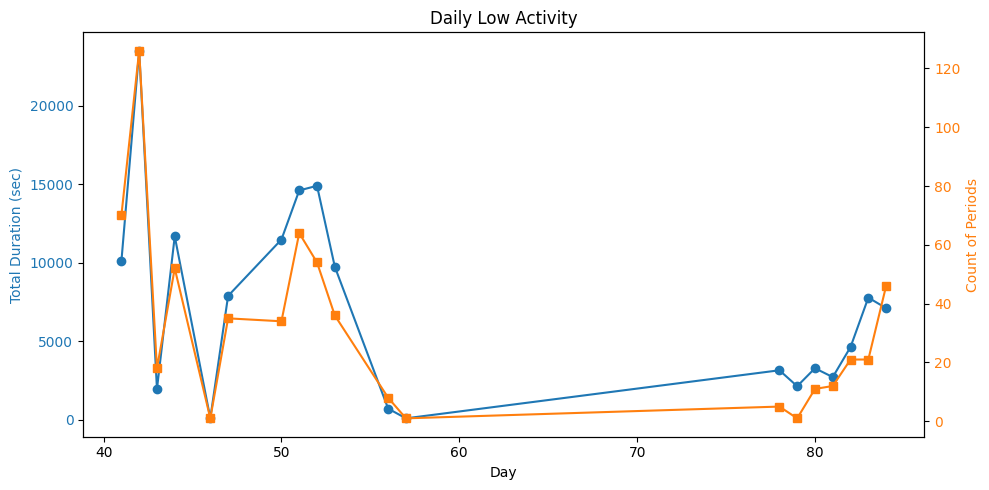

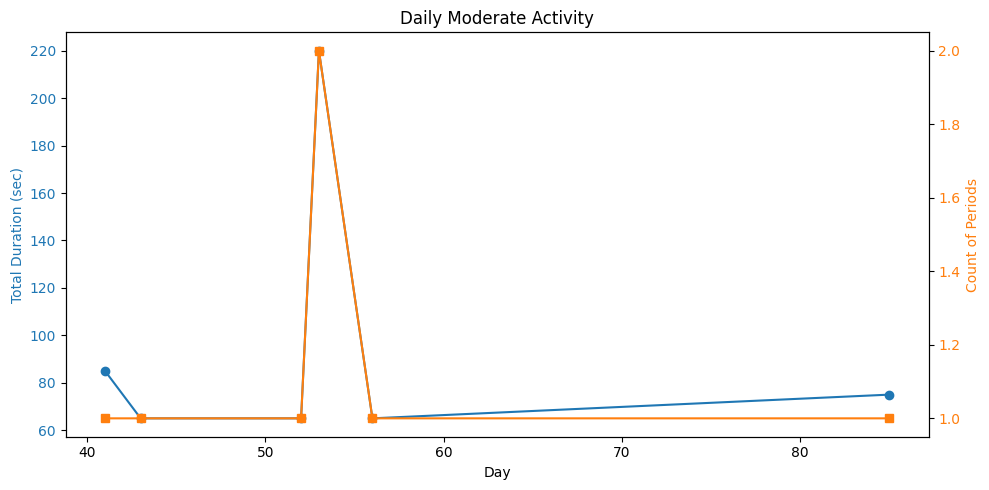

In [57]:
for activity_type in ['low', 'moderate']:
    activity_data = activity_periods[activity_periods['activity_type'] == activity_type]

    daily_stats = activity_data.groupby('day').agg(
        total_duration=('duration_sec', 'sum'),
        count_periods=('duration_sec', 'size')
    )
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Total Duration (sec)', color='tab:blue')
    ax1.plot(daily_stats.index, daily_stats['total_duration'], 
             color='tab:blue', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Count of Periods', color='tab:orange')
    ax2.plot(daily_stats.index, daily_stats['count_periods'], 
             color='tab:orange', marker='s')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    plt.title(f'Daily {activity_type.capitalize()} Activity')
    fig.tight_layout()
    plt.show()

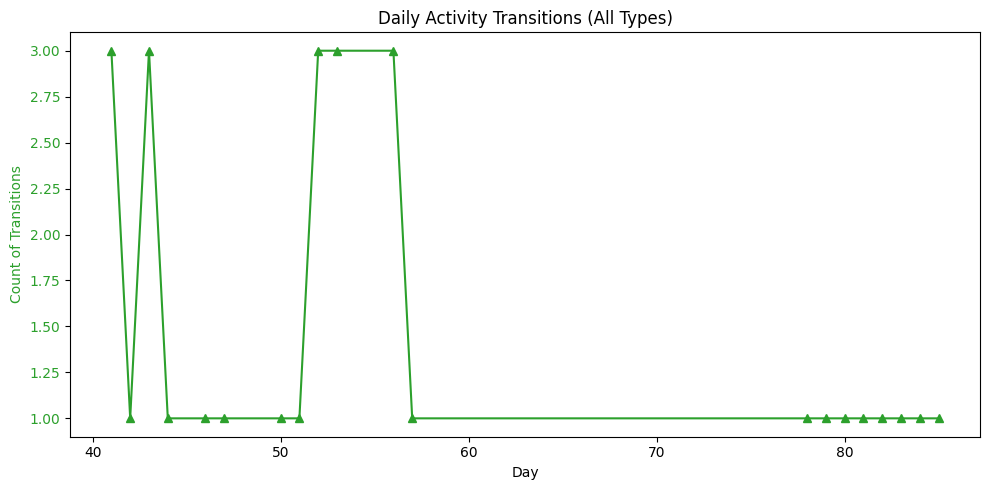

In [58]:
transitions_stats = activity_periods.groupby('day').agg(
    count_transitions=('transition_num', 'max')
)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel('Day')
ax.set_ylabel('Count of Transitions', color='tab:green')
ax.plot(transitions_stats.index, transitions_stats['count_transitions'], 
        color='tab:green', marker='^')
ax.tick_params(axis='y', labelcolor='tab:green')

plt.title('Daily Activity Transitions (All Types)')
fig.tight_layout()
plt.show()

# - Ideas for feature engeneering

Again, we are dealing with similar measures - periods of activity, so we can make similar features:

Aggregated  (mean, median, max, std):
- Total duration of different of activity per day
- Number of different activity boots per day

In [59]:
activity_summary = {}

for act_type in ['low', 'moderate']:
    activity_data = activity_periods[activity_periods['activity_type'] == act_type]
    
    stats = activity_data.groupby('day').agg(
        total_duration=('duration_sec', 'sum'),
        count_periods=('duration_sec', 'size')
    ).agg(['median', 'max', 'std'])
    
    for stat in ['median', 'max', 'std']:
        activity_summary[f'{act_type}_duration_{stat}'] = stats.loc[stat, 'total_duration']
        activity_summary[f'{act_type}_count_periods_{stat}'] = stats.loc[stat, 'count_periods']

daily_transitions = activity_periods.groupby('day')['transition_num'].max()

trans_stats = daily_transitions.agg(['median', 'max', 'std'])
for stat in ['median', 'max', 'std']:
    activity_summary[f'transitions_{stat}'] = trans_stats[stat]

features = pd.DataFrame([activity_summary])
features

,low_duration_median,low_count_periods_median,low_duration_max,low_count_periods_max,low_duration_std,low_count_periods_std,moderate_duration_median,moderate_count_periods_median,moderate_duration_max,moderate_count_periods_max,moderate_duration_std,moderate_count_periods_std,transitions_median,transitions_max,transitions_std
0,7115.0,21.0,23505.0,126.0,6183.344351,31.514222,70.0,1.0,220.0,2.0,61.352805,0.408248,1.0,3.0,0.888523


# Activity and Light Exposure

Investigate the correlation between ambient light levels and activity levels by looking at how ENMO varies with light exposure.

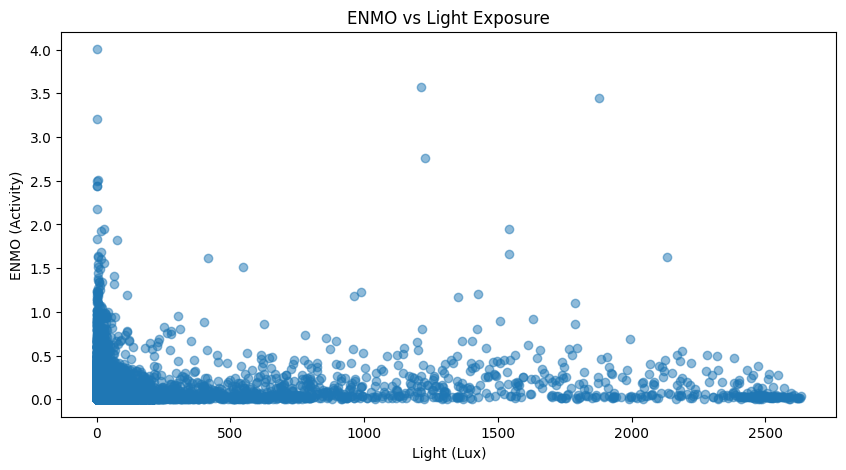

Correlation between Light and ENMO: 0.12972936257372378


In [60]:
plt.figure(figsize=(10, 5))
plt.scatter(worn_data['light'], worn_data['enmo'], alpha=0.5)
plt.xlabel('Light (Lux)')
plt.ylabel('ENMO (Activity)')
plt.title('ENMO vs Light Exposure')
plt.show()

correlation_light_enmo = worn_data[['light', 'enmo']].corr().iloc[0, 1]
print(f"Correlation between Light and ENMO: {correlation_light_enmo}")

<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
        <li>There seems to be a slight positive correlation od 0.2 between ENMO and Light Exposure, meaning that higher light exposure tends to be associated with higher activity, but no clear trend
        <li>Most of the recorded activity happened in relatively low-light environments.
    </ul>
</div>

# Seasonal & Week-based Trends

Look at how the activity levels change over time. We start with changes by weekday:

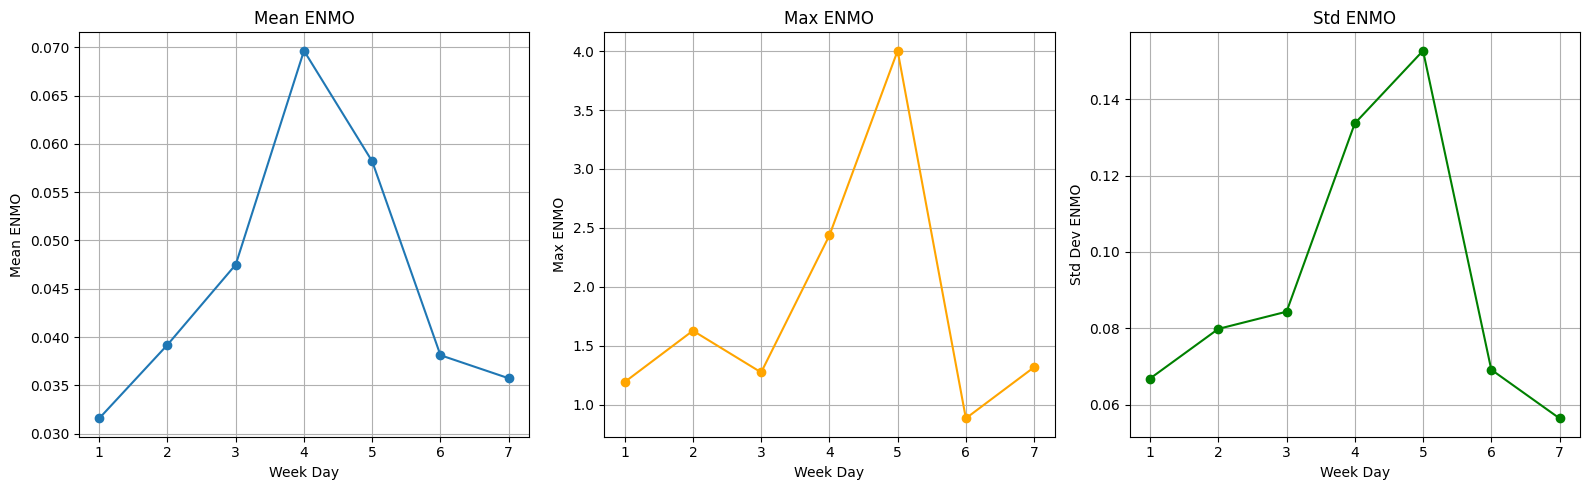

In [61]:
daily_activity = worn_data.groupby('weekday')['enmo'].agg(['mean', 'max', 'std', 'count'])

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(daily_activity.index, daily_activity['mean'], marker='o')
plt.title('Mean ENMO')
plt.xlabel('Week Day')
plt.ylabel('Mean ENMO')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(daily_activity.index, daily_activity['max'], marker='o', color='orange')
plt.title('Max ENMO')
plt.xlabel('Week Day')
plt.ylabel('Max ENMO')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(daily_activity.index, daily_activity['std'], marker='o', color='green')
plt.title('Std ENMO')
plt.xlabel('Week Day')
plt.ylabel('Std Dev ENMO')
plt.grid(True)

plt.tight_layout()
plt.show()

In [62]:
daily_activity = daily_activity.reset_index()
daily_activity.columns = ['Weekday', 'Mean ENMO', 'Max ENMO', 'Std ENMO', 'Count']
daily_activity

,Weekday,Mean ENMO,Max ENMO,Std ENMO,Count
0,1,0.031589,1.191064,0.066897,4780
1,2,0.039202,1.626995,0.079876,3913
2,3,0.047503,1.273030,0.084379,3996
3,4,0.069642,2.435782,0.133636,6545
4,5,0.058188,4.004276,0.152648,10223
5,6,0.038124,0.882914,0.069200,5307
6,7,0.035736,1.317071,0.056475,8566


The mean ENMO by week:

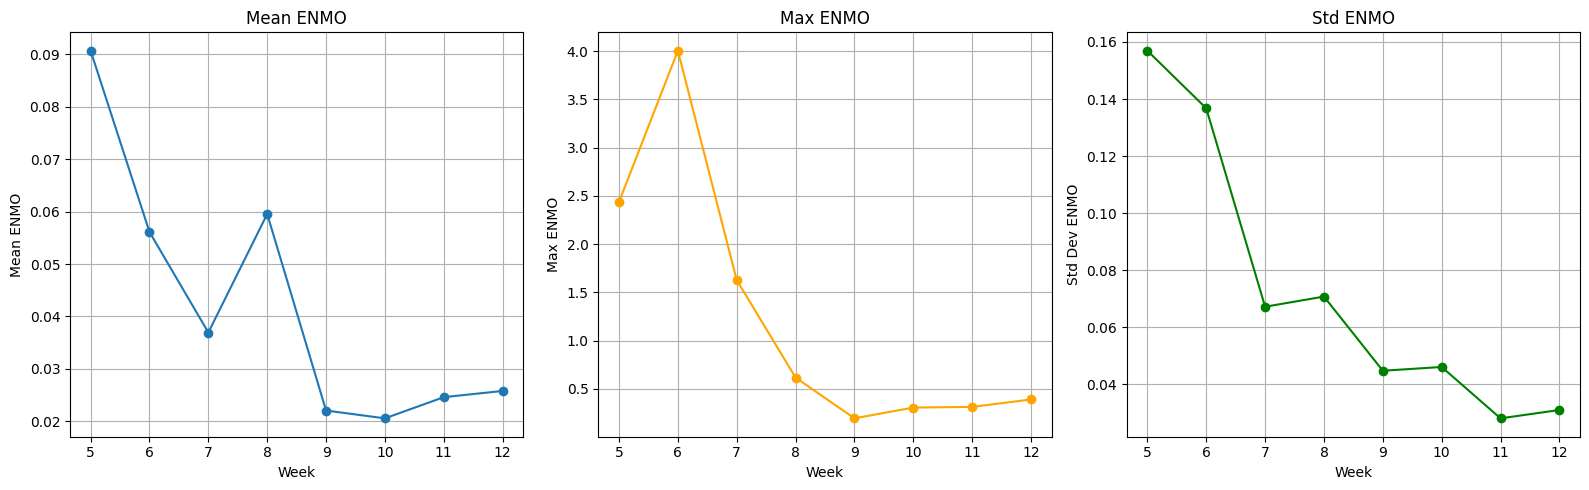

In [63]:
worn_data['week'] = worn_data['relative_date_PCIAT'] // 7
weekly_activity = worn_data.groupby('week')['enmo'].agg(['mean', 'max', 'std', 'count'])

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(weekly_activity.index, weekly_activity['mean'], marker='o')
plt.title('Mean ENMO')
plt.xlabel('Week')
plt.ylabel('Mean ENMO')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(weekly_activity.index, weekly_activity['max'], marker='o', color='orange')
plt.title('Max ENMO')
plt.xlabel('Week')
plt.ylabel('Max ENMO')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(weekly_activity.index, weekly_activity['std'], marker='o', color='green')
plt.title('Std ENMO')
plt.xlabel('Week')
plt.ylabel('Std Dev ENMO')
plt.grid(True)

plt.tight_layout()
plt.show()

In [64]:
weekly_activity = weekly_activity.reset_index()
weekly_activity.columns = ['Week', 'Mean ENMO', 'Max ENMO', 'Std ENMO', 'Count']
weekly_activity

,Week,Mean ENMO,Max ENMO,Std ENMO,Count
0,5.0,0.090690,2.435782,0.156932,4453
1,6.0,0.056116,4.004276,0.136741,15415
2,7.0,0.036941,1.626995,0.067163,14794
3,8.0,0.059549,0.616573,0.070727,657
4,9.0,0.022061,0.194116,0.044719,83
5,10.0,0.020572,0.305785,0.046041,118
6,11.0,0.024611,0.312680,0.028031,5852
7,12.0,0.025799,0.389754,0.030955,1958


By season:

In [65]:
season_activity = worn_data.groupby('quarter')['enmo'].agg(['mean', 'max', 'std', 'count'])
season_activity = season_activity.reset_index()
season_activity.columns = ['Season', 'Mean ENMO', 'Max ENMO', 'Std ENMO', 'Count']
season_activity

,Season,Mean ENMO,Max ENMO,Std ENMO,Count
0,3,0.047388,4.004276,0.106351,43330


<div style="line-height:24px; font-size:16px;border-left: 5px solid silver; padding-left: 26px;"> 
    💡 Note: 
    <ul style="list-style:circle">
<li>Seems to be an increase in both activity intensity and variability over the weekends
<li>The noise from the last two weeks is clearly distorting the statistics, so it is essential to clean the data before generating features.
<li>There is also a little seasonal variation, so seasons of data collection may be useful for modelling.
    </ul>
</div>




<div style="width: 100%; display: flex; justify-content: space-between; 
            align-items: center; padding: 10px 0; background-color: #fff;">
    <img src="https://img.icons8.com/?size=100&id=CPrgx1M8R2zn&format=png&color=000000"  
         alt="Flower" style="margin: 0 10px;">
    <img src="https://img.icons8.com/?size=100&id=VSVI10CNDTxj&format=png&color=000000"  
         alt="Flower" style="margin: 0 10px;">
    <img src="https://img.icons8.com/?size=100&id=CPrgx1M8R2zn&format=png&color=000000"  
         alt="Flower" style="margin: 0 10px;">
</div>

In [66]:
stats_df

,id,non_wear_percentage,unique_days,enmo_mean,enmo_std,enmo_min,enmo_25%,enmo_50%,enmo_75%,enmo_max,...,light_75%,light_max,battery_voltage_mean,battery_voltage_std,battery_voltage_min,battery_voltage_25%,battery_voltage_50%,battery_voltage_75%,battery_voltage_max,n_records
0,00115b9f,0.000000,40,0.047388,0.106351,0.0,0.006432,0.023637,0.041420,4.004276,...,15.000000,2633.250000,4053.579102,112.404045,3824.000000,4028.666748,4070.0,4147.0,4188.5,43330.0
1,001f3379,65.570793,24,0.016461,0.040610,0.0,0.000845,0.006559,0.015562,2.952888,...,10.533334,2597.800049,3984.540039,153.086365,3098.166748,3947.000000,4000.0,4076.0,4175.0,129316.0


In [67]:
stats_df.columns

Index(['id', 'non_wear_percentage', 'unique_days', 'enmo_mean', 'enmo_std',
       'enmo_min', 'enmo_25%', 'enmo_50%', 'enmo_75%', 'enmo_max',
       'anglez_mean', 'anglez_std', 'anglez_min', 'anglez_25%', 'anglez_50%',
       'anglez_75%', 'anglez_max', 'light_mean', 'light_std', 'light_min',
       'light_25%', 'light_50%', 'light_75%', 'light_max',
       'battery_voltage_mean', 'battery_voltage_std', 'battery_voltage_min',
       'battery_voltage_25%', 'battery_voltage_50%', 'battery_voltage_75%',
       'battery_voltage_max', 'n_records'],
      dtype='object')